In [5]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys, collections, os, argparse
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

In [ ]:
# load kallisto bus output dataset
# demonstrate how cell-gene mat is generated
# dont run this

cell_gene = collections.defaultdict(lambda: collections.defaultdict(float))
pbar=None
pumi=None
with open('./count_out/output_unfiltered.txt') as f:
    gs = set()
    for line in f:
        l = line.split()
        barcode,umi,ec,count = line.split()
        ec = int(ec)
        
        # Here shows how umi collision collapse in kallisto
        # This collapse methods is different from the description in the paper which result in more detected gene
        if barcode == pbar:
            # same barcode
            if umi == pumi:
                # same UMI, let's update with intersection of genelist
                gl = ec2g(ec)
                gs.intersection_update(gl)
            else:
                # new UMI, process the previous gene set
                for g in gs:
                    cell_gene[barcode][g] += 1.0/len(gs)
                # record new umi, reset gene set
                pumi = umi
                gs = set(ec2g(ec))
        else:
            # work with previous gene list
            for g in gs:
                cell_gene[pbar][g] += 1.0/len(gs)
            
            if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
                del cell_gene[pbar]
            
            pbar = barcode
            pumi = umi
            
            gs = set(ec2g(ec))
    #remember the last gene
    for g in gs:
        cell_gene[pbar][g] += 1.0/len(gs)
        
    if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
        del cell_gene[pbar]

In [ ]:
barcode_hist = collections.defaultdict(int)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    s = len([cg[g] for g in cg])
    barcode_hist[barcode] += s

## Check barcode-gene distribution

In [ ]:
threshold = 0 # this filters the data by gene count
bcv = [x for b,x in barcode_hist.items() if x > 500] 
_ = plt.hist(bcv,bins=40, log=True)
plt.rcParams["figure.figsize"] = [9,6]
plt.xlabel("Number of gene counts")
plt.ylabel("Number of barcodes")
print(len(bcv))

In [6]:
import scanpy as sc
import anndata
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io
import seaborn as sns

## Import cell-gene count matrix

In [196]:
_p = [f"./count_out_SRR77229{str(i)}/counts_unfiltered/adata.h5ad" for i in range(39, 43)]
samples = [f'SRR77229{str(i)}' for i in range(38, 43)]

In [197]:
# read all PBMC data in dict
adatas = {sample: anndata.read(f) for sample, f in zip(samples, _p)}

In [198]:
adatas

{'SRR7722938': AnnData object with n_obs × n_vars = 133256 × 59412,
 'SRR7722939': AnnData object with n_obs × n_vars = 100707 × 59412,
 'SRR7722940': AnnData object with n_obs × n_vars = 120446 × 59412,
 'SRR7722941': AnnData object with n_obs × n_vars = 147145 × 59412}

### add mito content flag

In [199]:
# add mito label for later qc func
for adata in adatas.values():
    adata.var['mito'] = adata.var.index.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mito'], inplace=True)

## Knee point

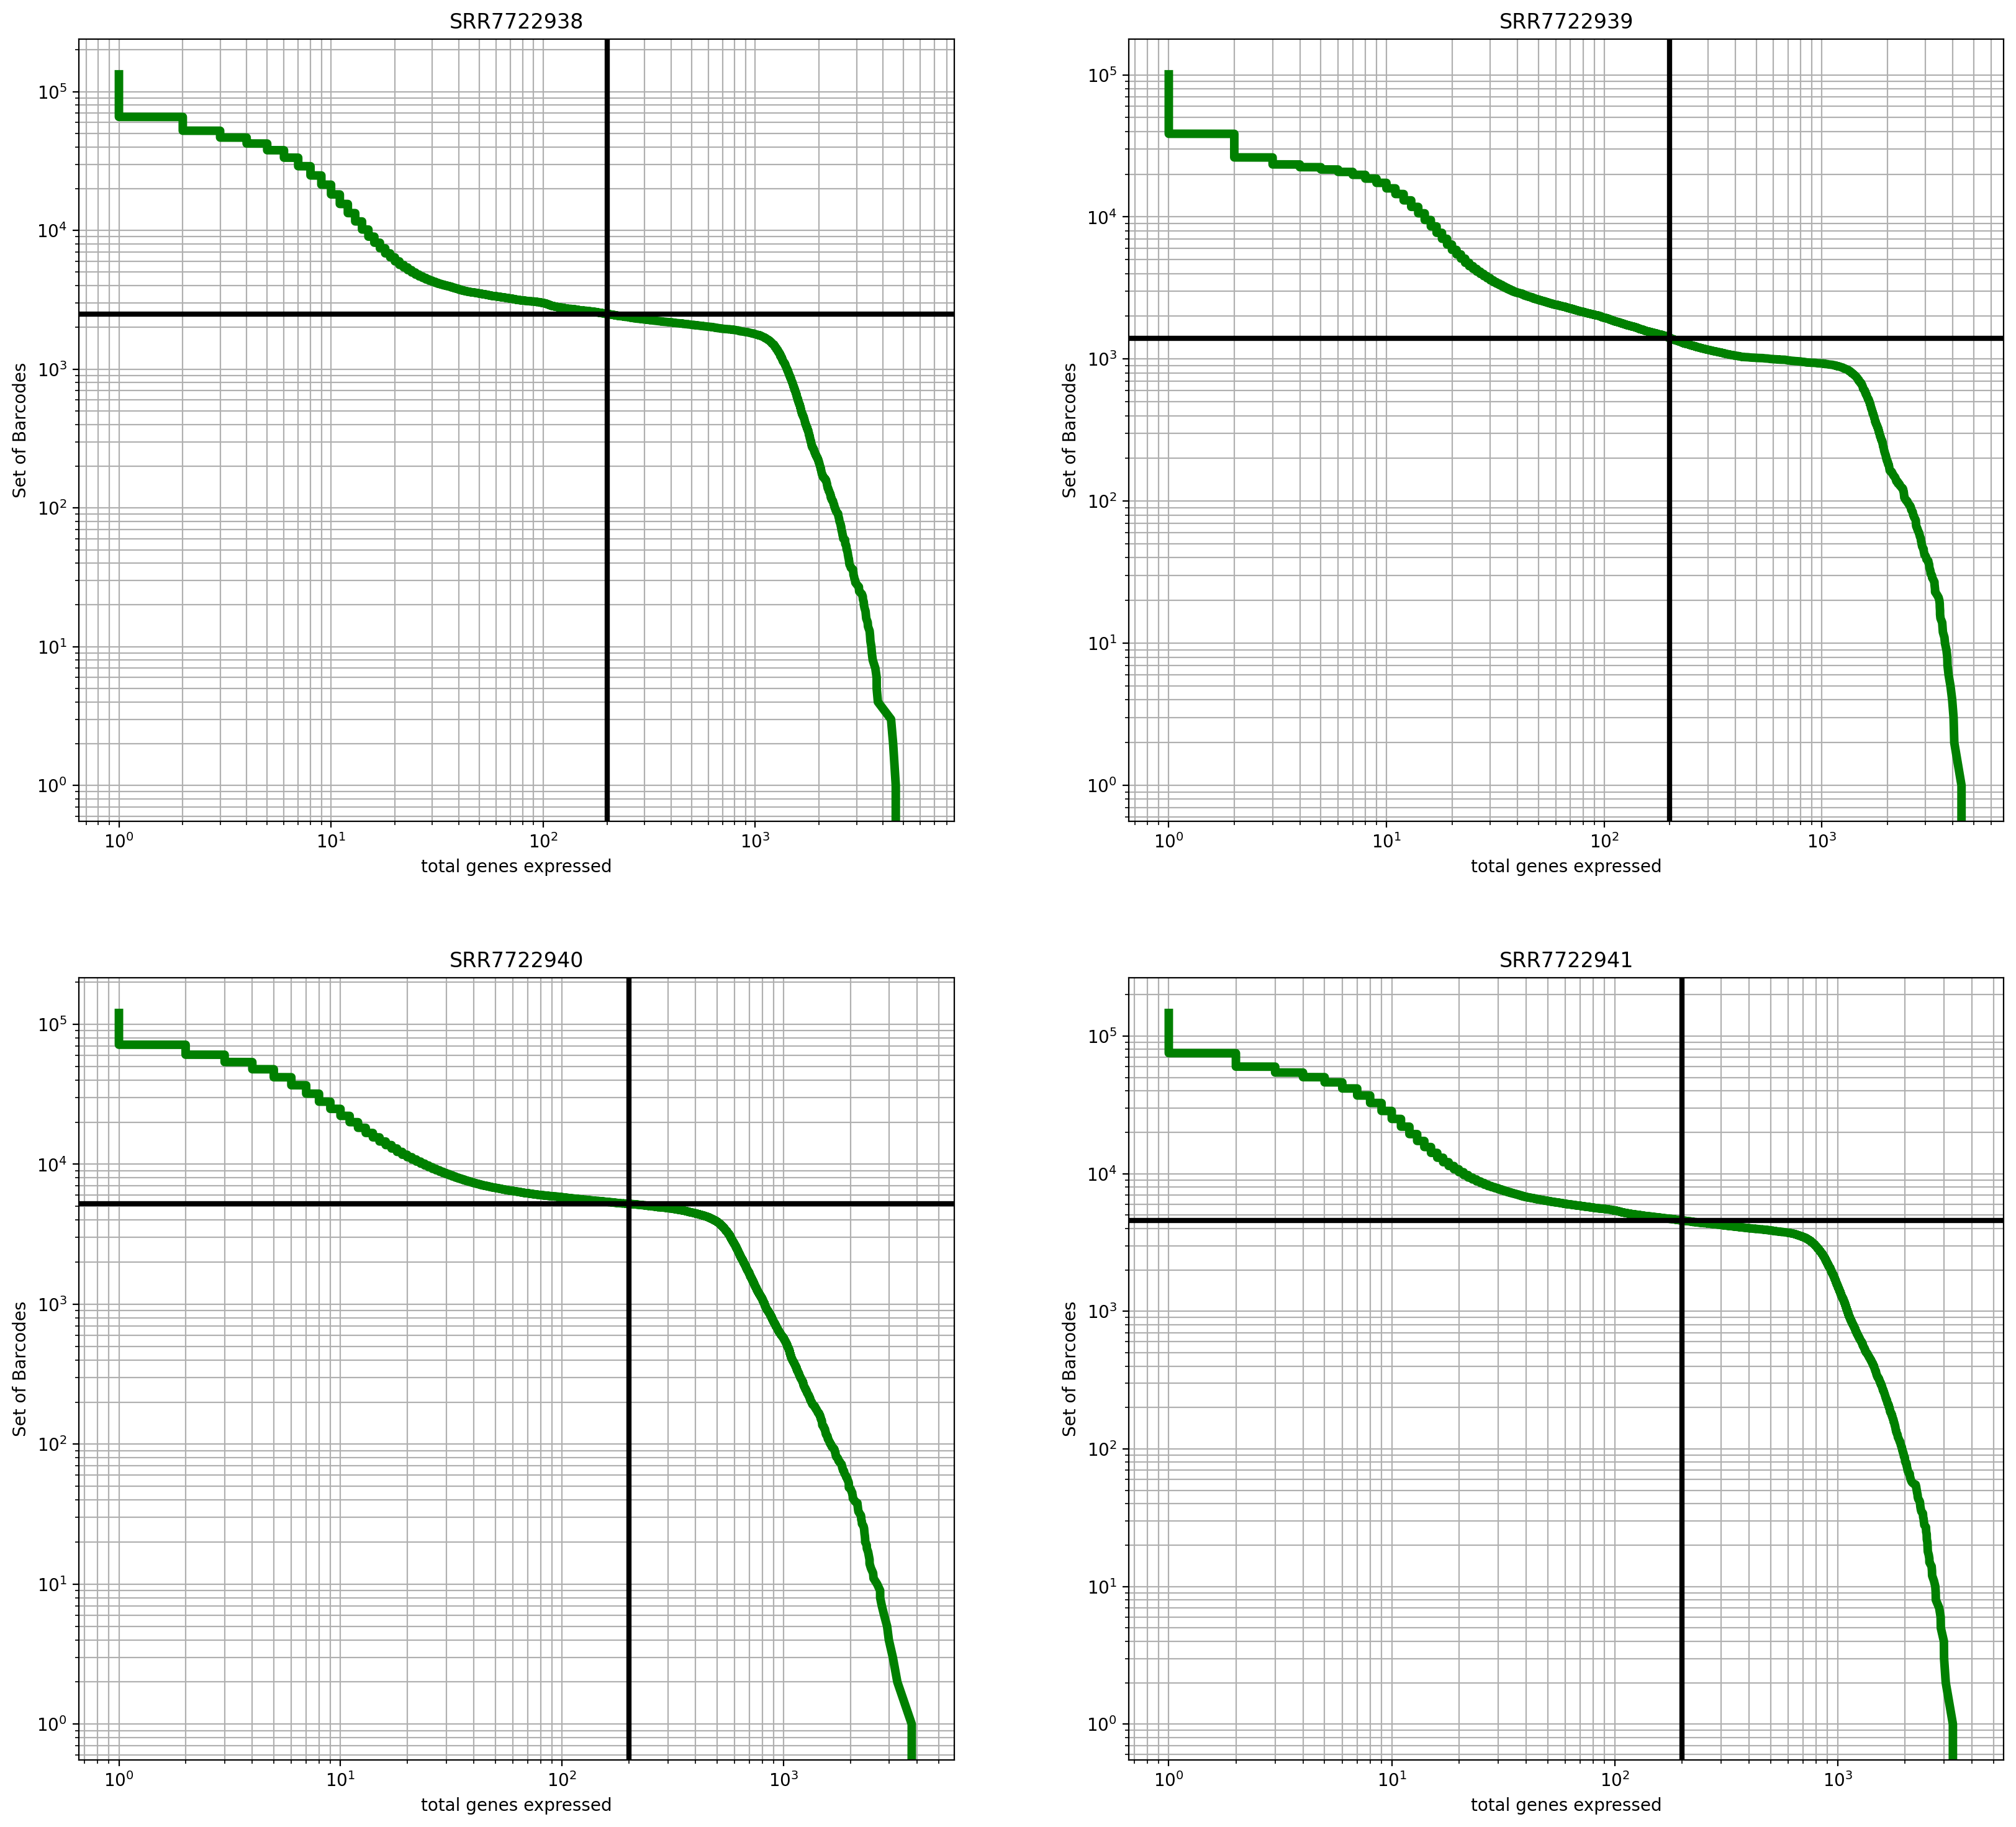

In [201]:
# { run: "auto", vertical-output: true }
# The idea is that "real" cells have a certain number of UMI counts 
# and that a threshold on the UMI counts filters those cells.
cutoff =  200

fig, axs = plt.subplots(2, 2, figsize=(20,18))

cell_filters = []
knees = []
for ax, (sample, adata) in zip(axs.flatten(), adatas.items()):
    # option 1 (describe in tutorial)
    # desc sorted total gene expressed per cell
#     knee = np.sort((np.array(adatas[i].X.sum(axis=1))).flatten())[::-1]
    knee= np.sort((np.array(np.sum(adata.X > 0, axis=1))).flatten())[::-1]
    knees.append(knee)
    # optioin 2 (describe in paper)
    # we ordered our digital expression matrix by the *total number of transcripts(umi count)* per
    # cell barcode, and plotted the cumulative fraction of all transcripts in the matrix for each successively
    # smaller cell barcode.
    # knee= np.sort((np.array(np.sum(adata.X > 0, axis=1))).flatten())[::-1]

    cell_set = np.arange(len(knee))
    num_cells = cell_set[knee > cutoff][::-1][0]
    cell_filters.append(num_cells)

    # option 1
    ax.loglog(knee, cell_set, linewidth=5, color="g")
    ax.axvline(x=cutoff, linewidth=3, color="k")
    ax.axhline(y=num_cells, linewidth=3, color="k")
    ax.set_xlabel("total genes expressed")
    ax.set_ylabel("Set of Barcodes")
    ax.grid(True, which='both')
    ax.set_title(sample)

plt.show()

In [202]:
for i in range(len(adatas.keys())):
    print(f"In {samples[i]}: {cell_filters[i]:,.0f} cells passed the {cutoff} UMI threshold")
    
print(f"{sum(cell_filters):,.0f} cells passed the {cutoff} UMI threshold in total")

In SRR7722938: 2,502 cells passed the 200 UMI threshold
In SRR7722939: 1,405 cells passed the 200 UMI threshold
In SRR7722940: 5,214 cells passed the 200 UMI threshold
In SRR7722941: 4,569 cells passed the 200 UMI threshold
13,690 cells passed the 200 UMI threshold in total


## Filter data

### Cell filter
    1. minimum 200 genes expressed in each cell
    2. maximum 2500 genes expressed in each cell
### gene filter
    1. gene must be expressed in at least 1 cells
    2. at least 1 umi count contribute to the expressed gene

In [203]:
# empty droplets
for sample, adata in adatas.items():
    print(f"{sample}: n_cells: {adata.shape[0]}; n_genes: {adata.shape[1]}")

SRR7722938: n_cells: 133256; n_genes: 59412
SRR7722939: n_cells: 100707; n_genes: 59412
SRR7722940: n_cells: 120446; n_genes: 59412
SRR7722941: n_cells: 147145; n_genes: 59412


In [204]:
# Filter the cells according to the threshold determined from the knee plot
for sample, adata in adatas.items():
    adatas[sample] = adata[adata.obs['pct_counts_mito'] < 5, :]
    sc.pp.filter_cells(adatas[sample], min_genes=200)
    sc.pp.filter_cells(adatas[sample], max_genes=2500)
    sc.pp.filter_genes(adatas[sample], min_cells=1)
    sc.pp.filter_genes(adatas[sample], min_counts=1)
    
    

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [205]:
# empty droplets
for sample, adata in adatas.items():
    print(f"{sample}: n_cells: {adata.shape[0]}; n_genes: {adata.shape[1]}")

SRR7722938: n_cells: 1065; n_genes: 23555
SRR7722939: n_cells: 605; n_genes: 20483
SRR7722940: n_cells: 1966; n_genes: 22475
SRR7722941: n_cells: 1413; n_genes: 22998


## QC check after /w filtered matrix

In [206]:
for adata in adatas.values():
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mito'], inplace=True)

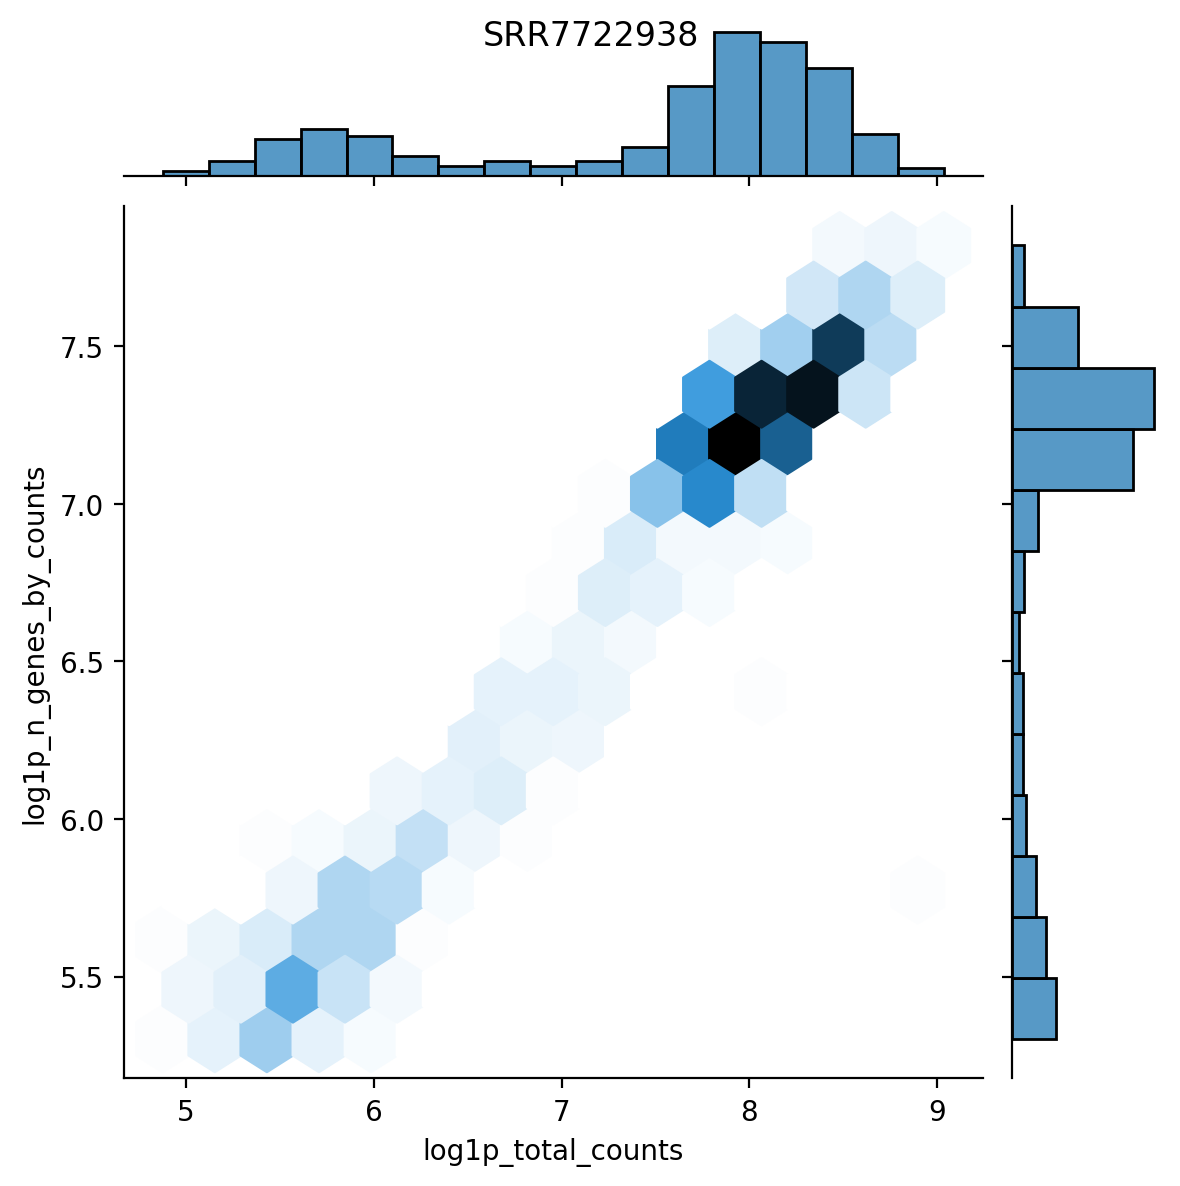

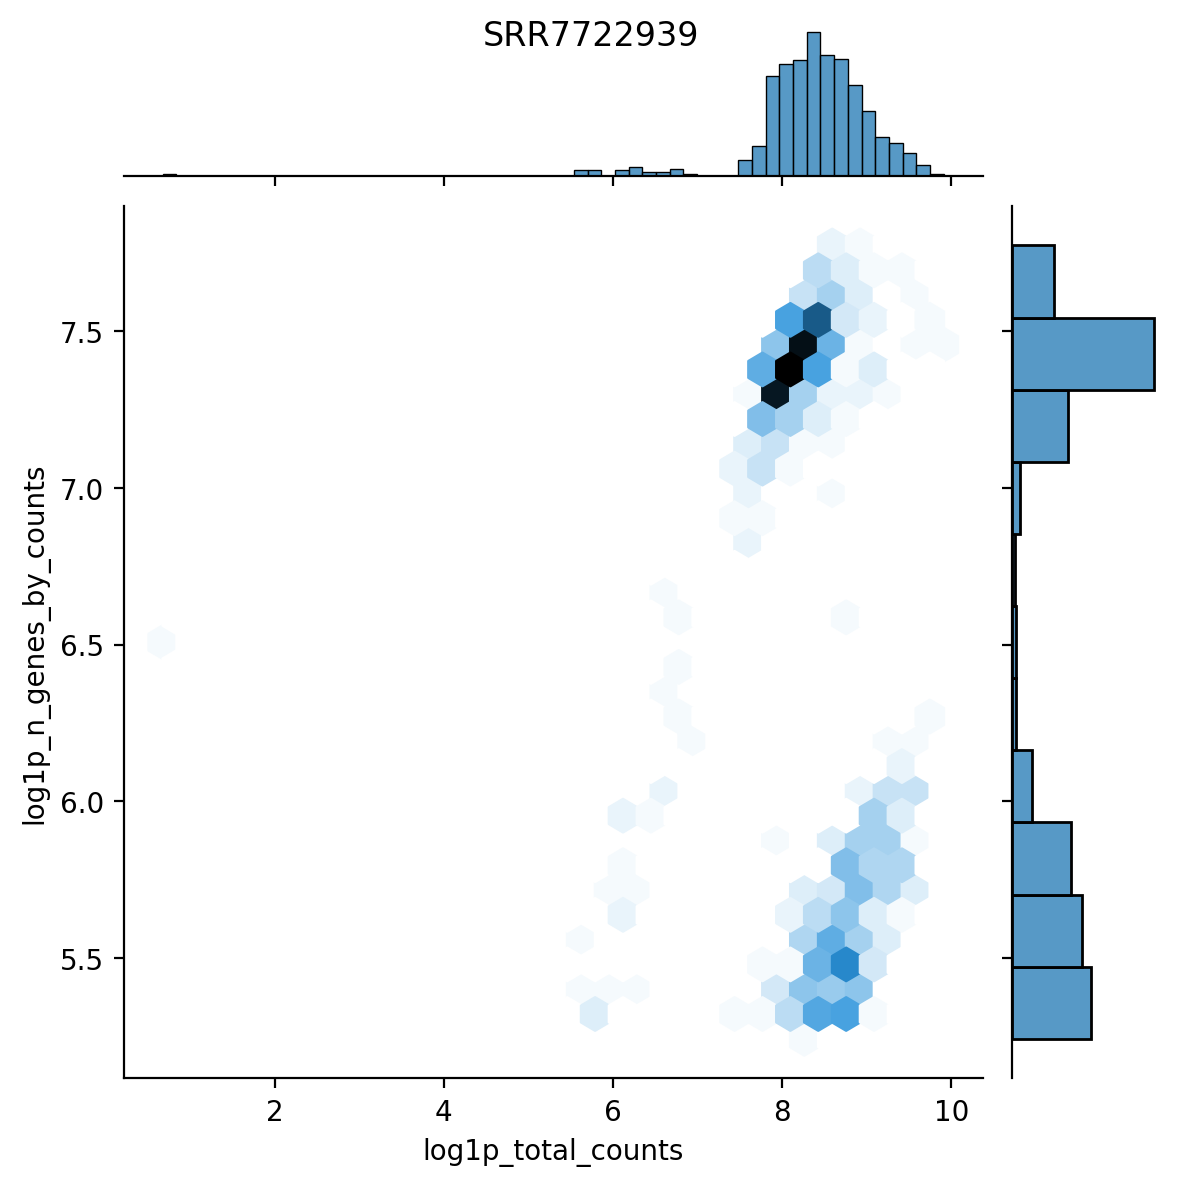

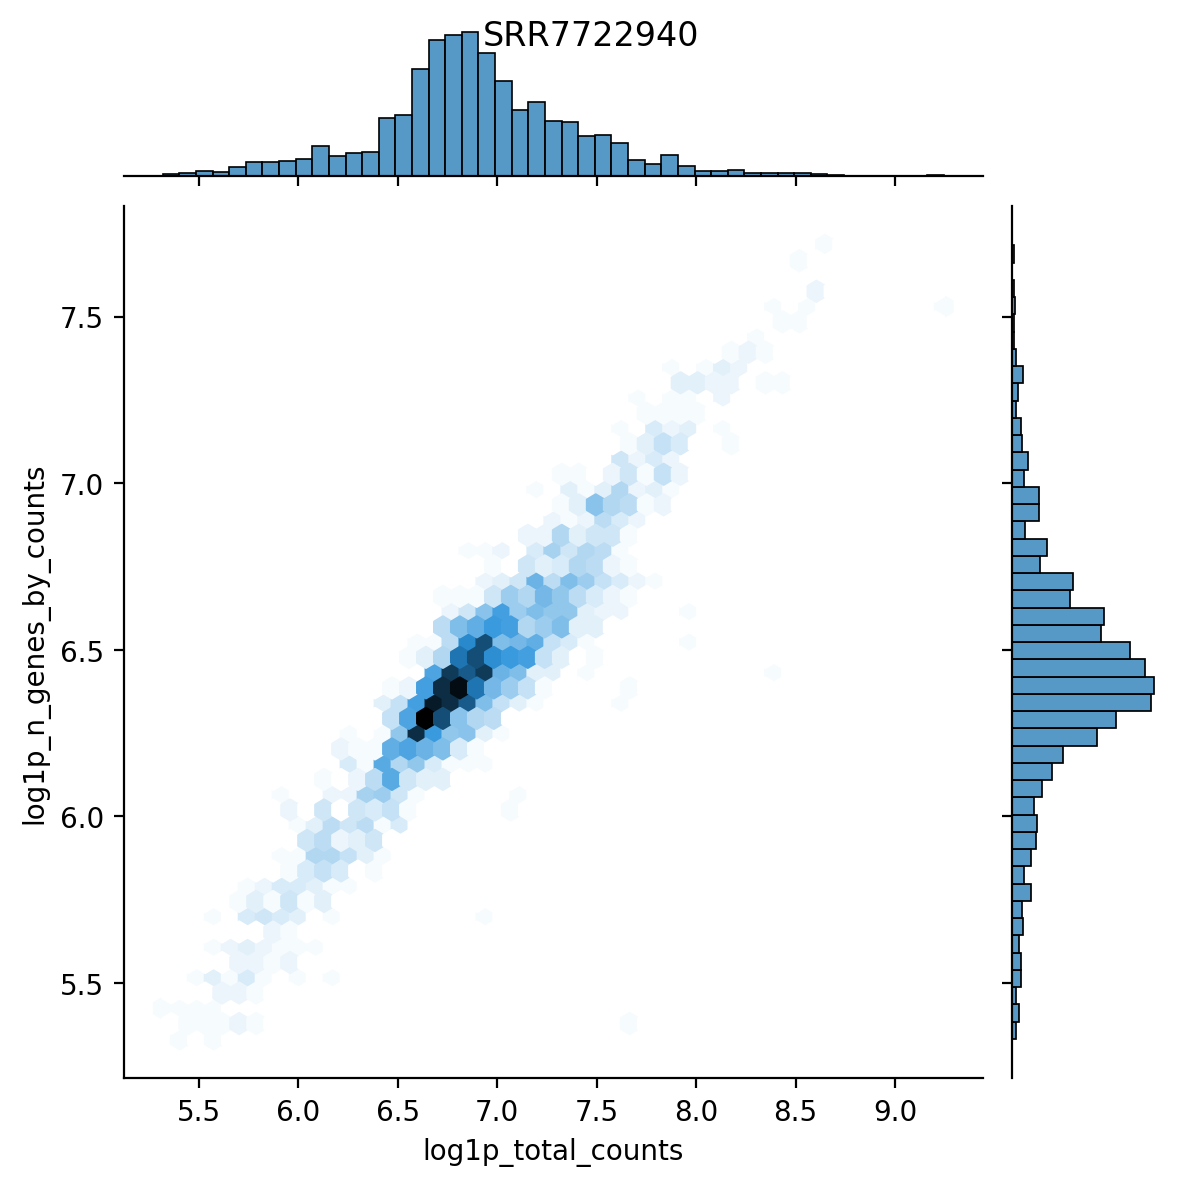

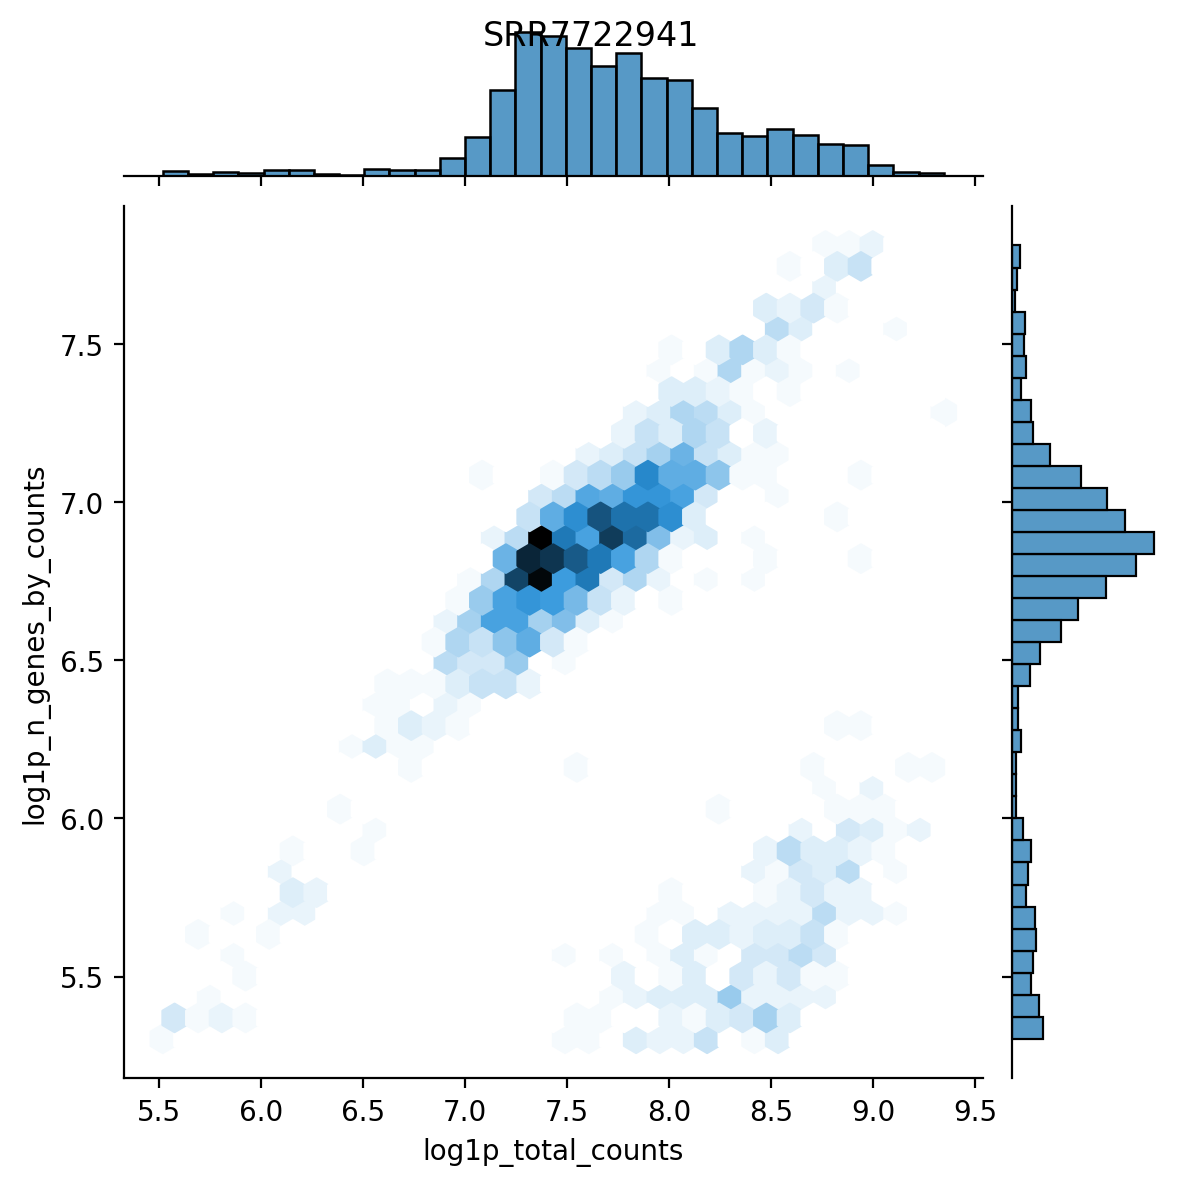

In [207]:
for sample, adata in adatas.items():
    sns.jointplot(
        data=adata.obs,
        x='log1p_total_counts',
        y='log1p_n_genes_by_counts',
        kind='hex',
    )
    plt.suptitle(sample)

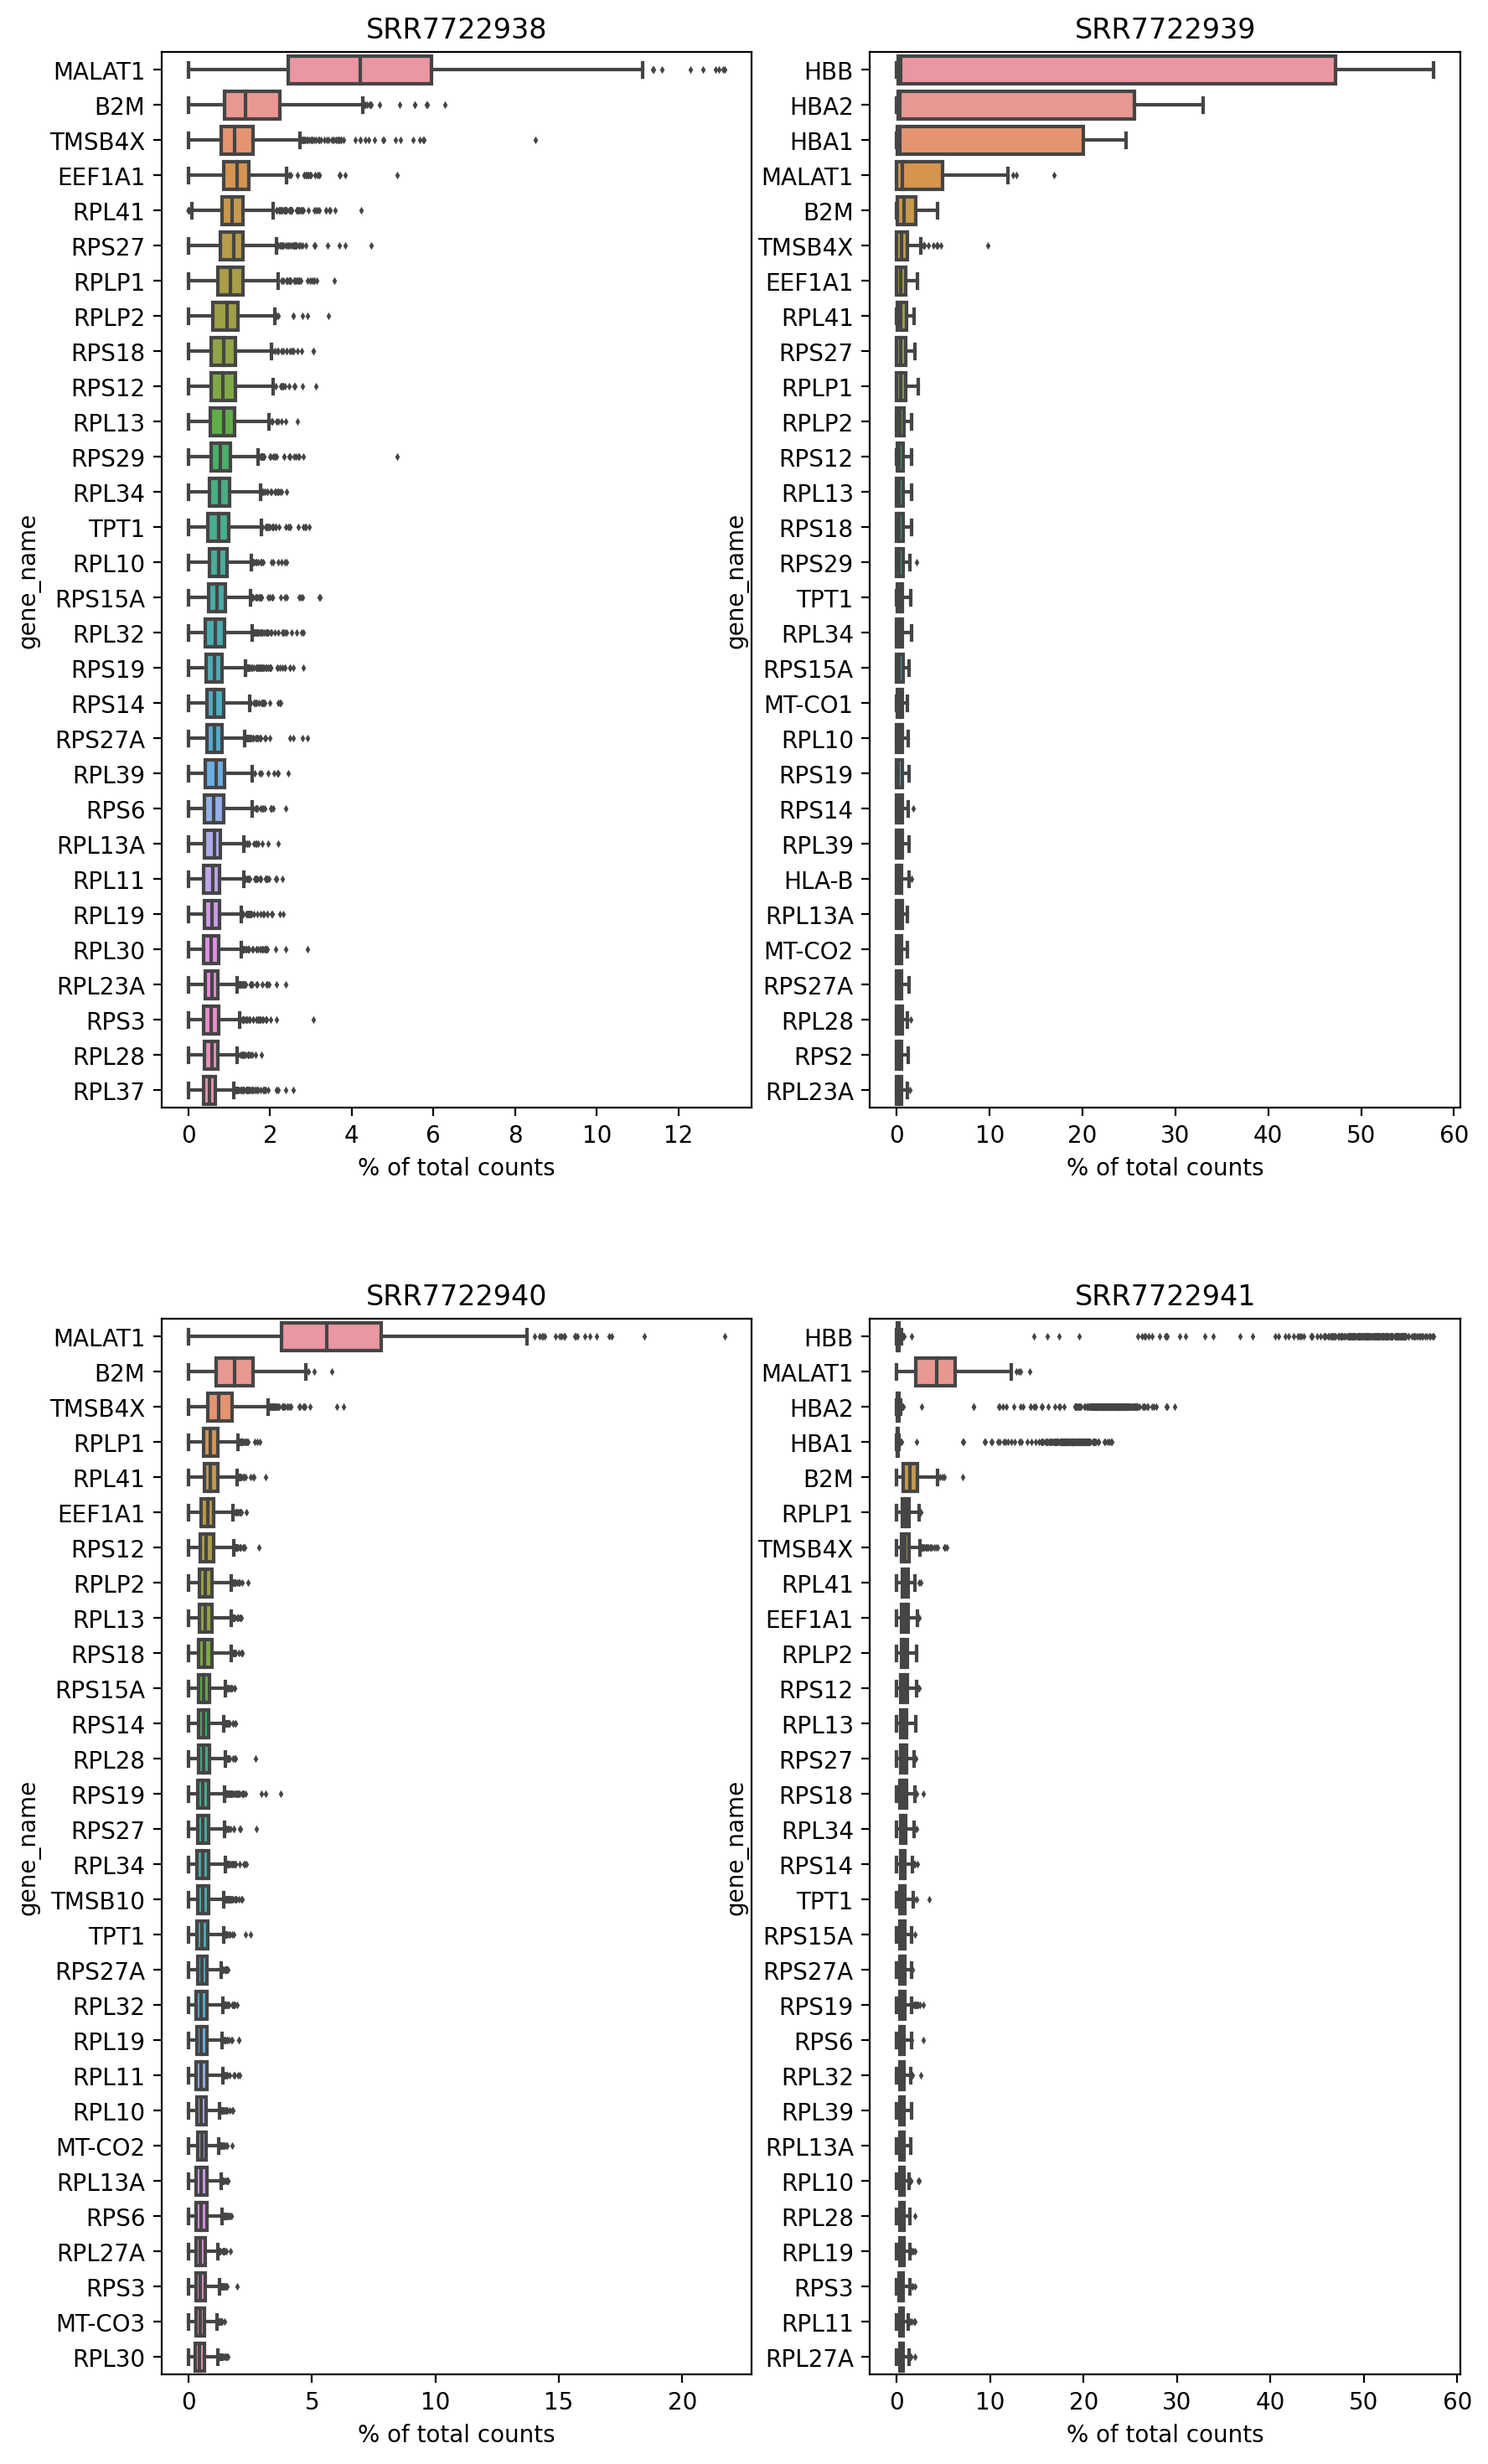

In [209]:
fig, axe = plt.subplots(2, 2, figsize=(10, 18))
for ax, (sample, adata) in zip(axe.flatten(), adatas.items()):
    sc.pl.highest_expr_genes(adata, ax=ax, show=False)
    ax.set_title(sample)

## Visualizing count dist

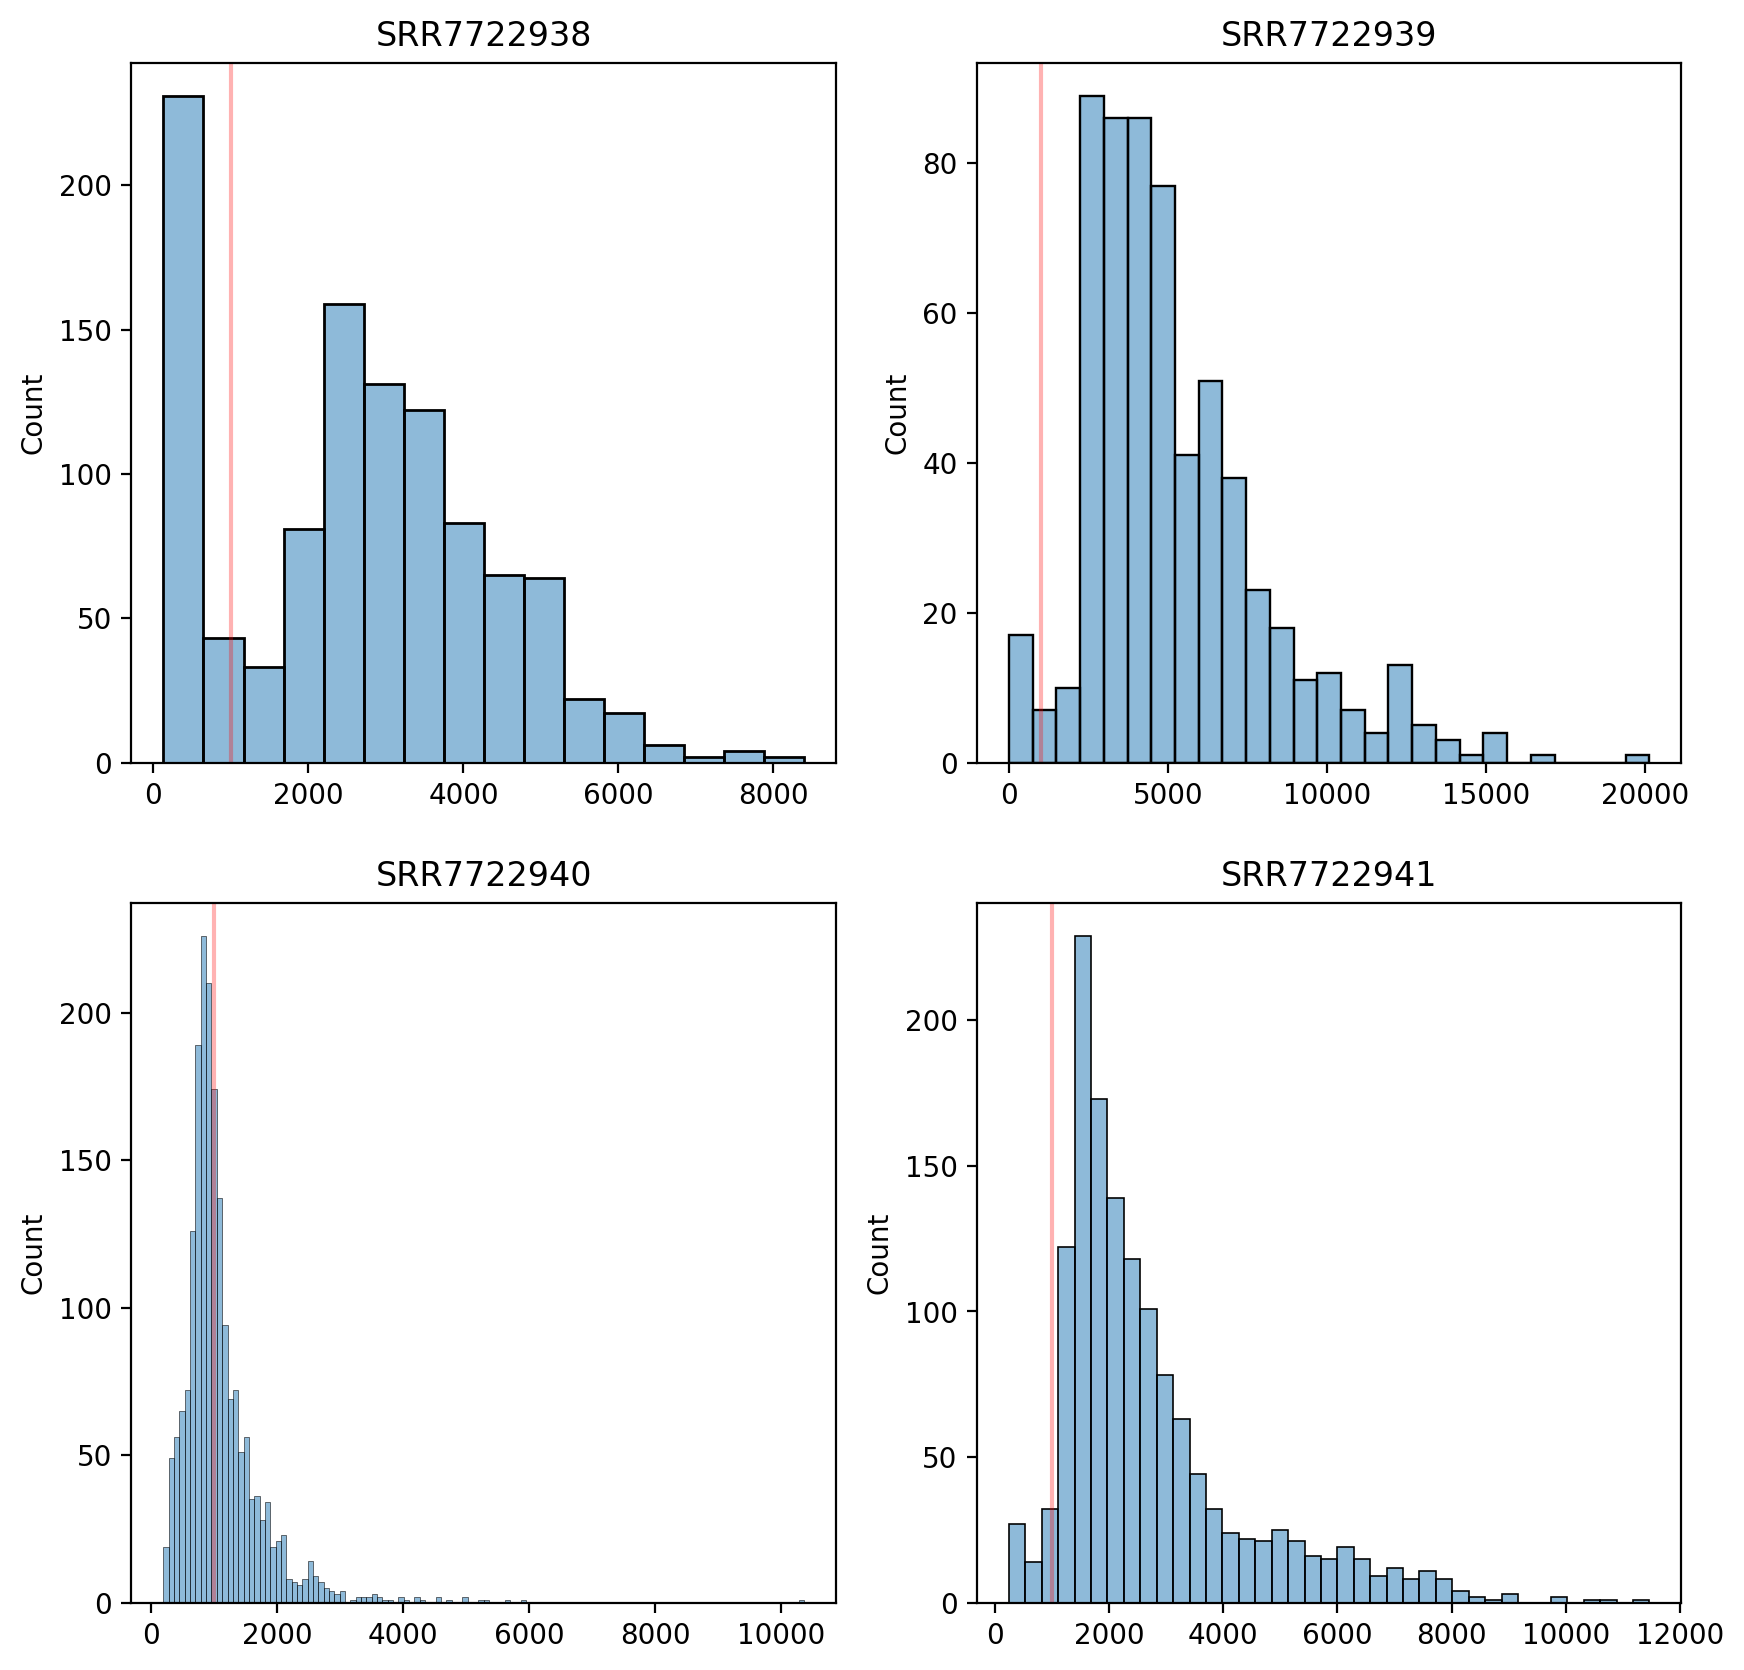

In [212]:
fig, axe = plt.subplots(2, 2, figsize=(10, 10))

for ax, (sample, adata) in zip(axe.flatten(), adatas.items()):
    sns.histplot(adata.X.sum(axis=1), ax=ax, legend=None).set_title(sample)
    ax.axvline(1000, color='r', alpha=.3)
# for adata in adatas:
#     sns.histplot(np.sum(adata.X>0, axis=1))

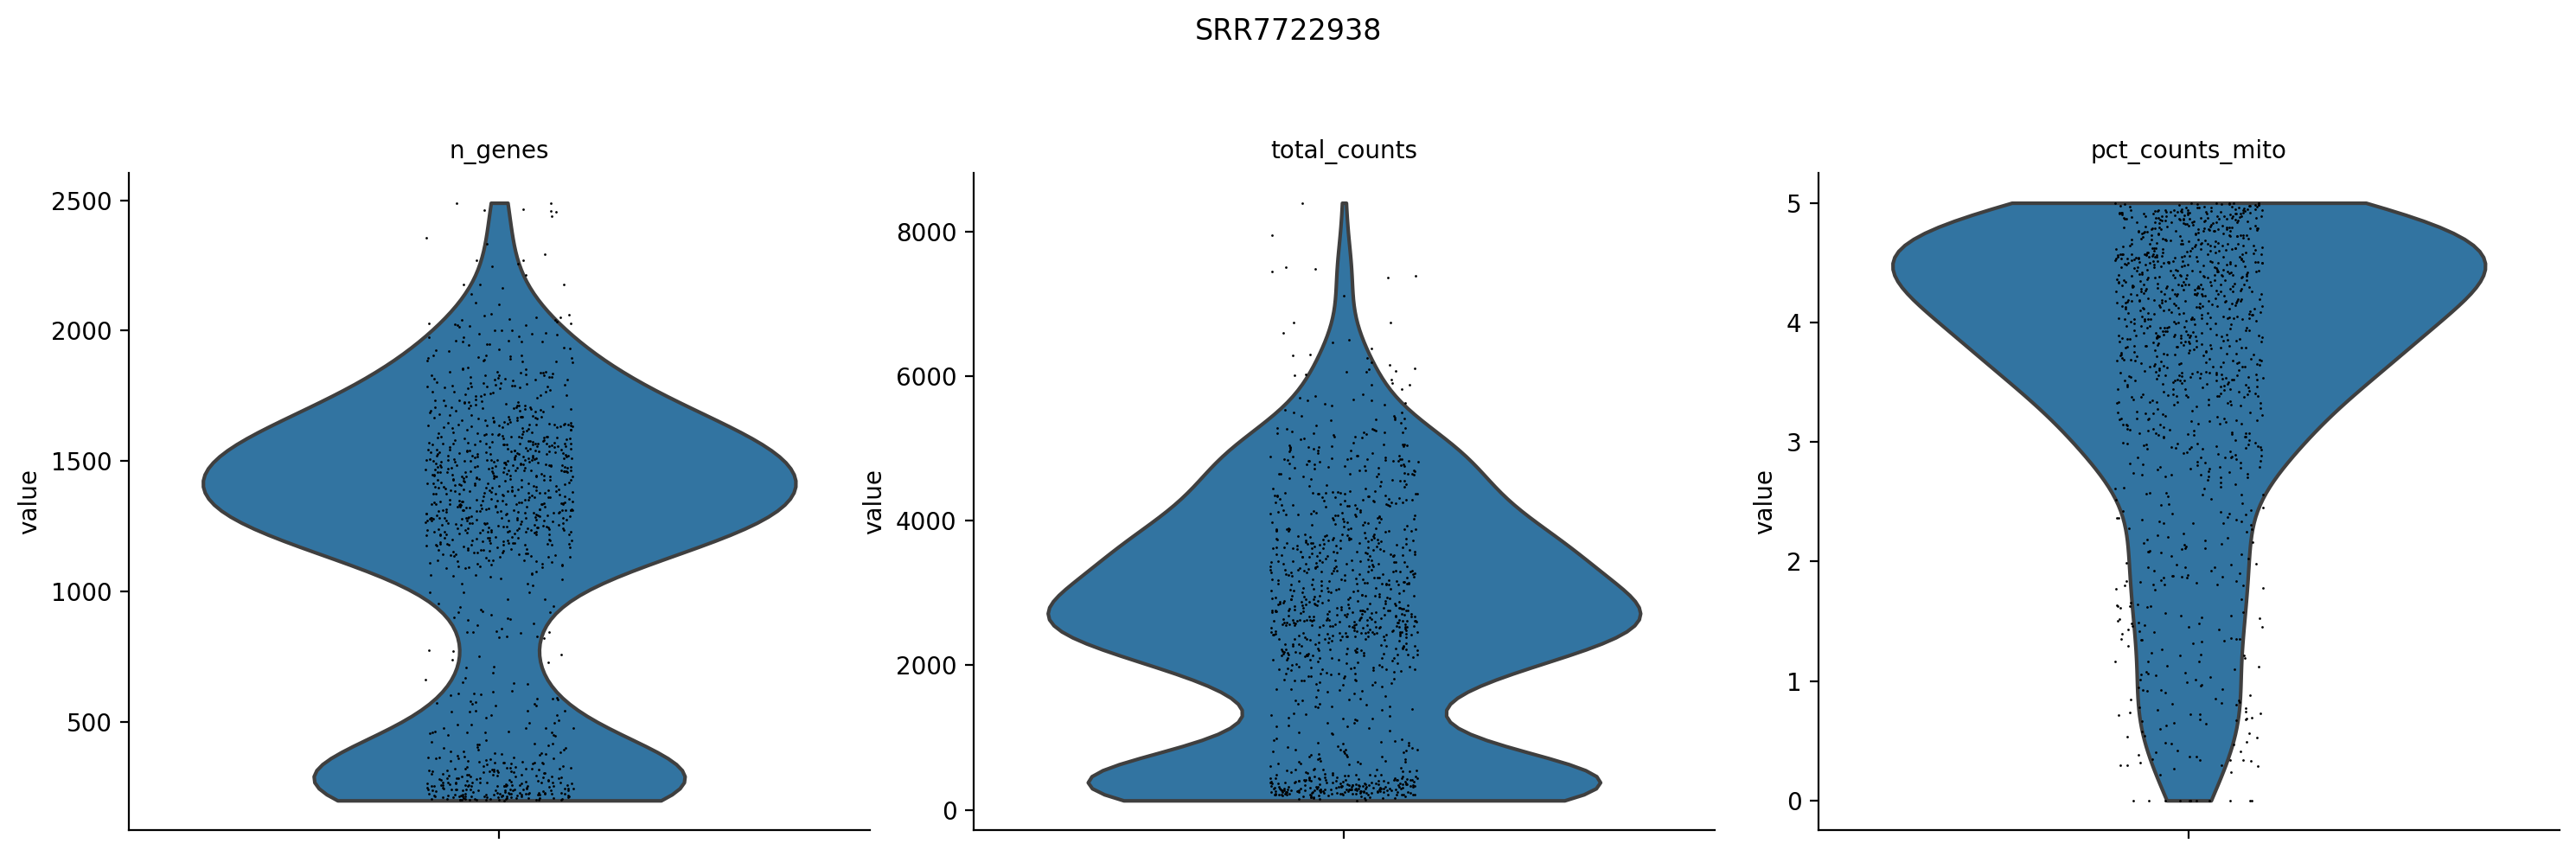

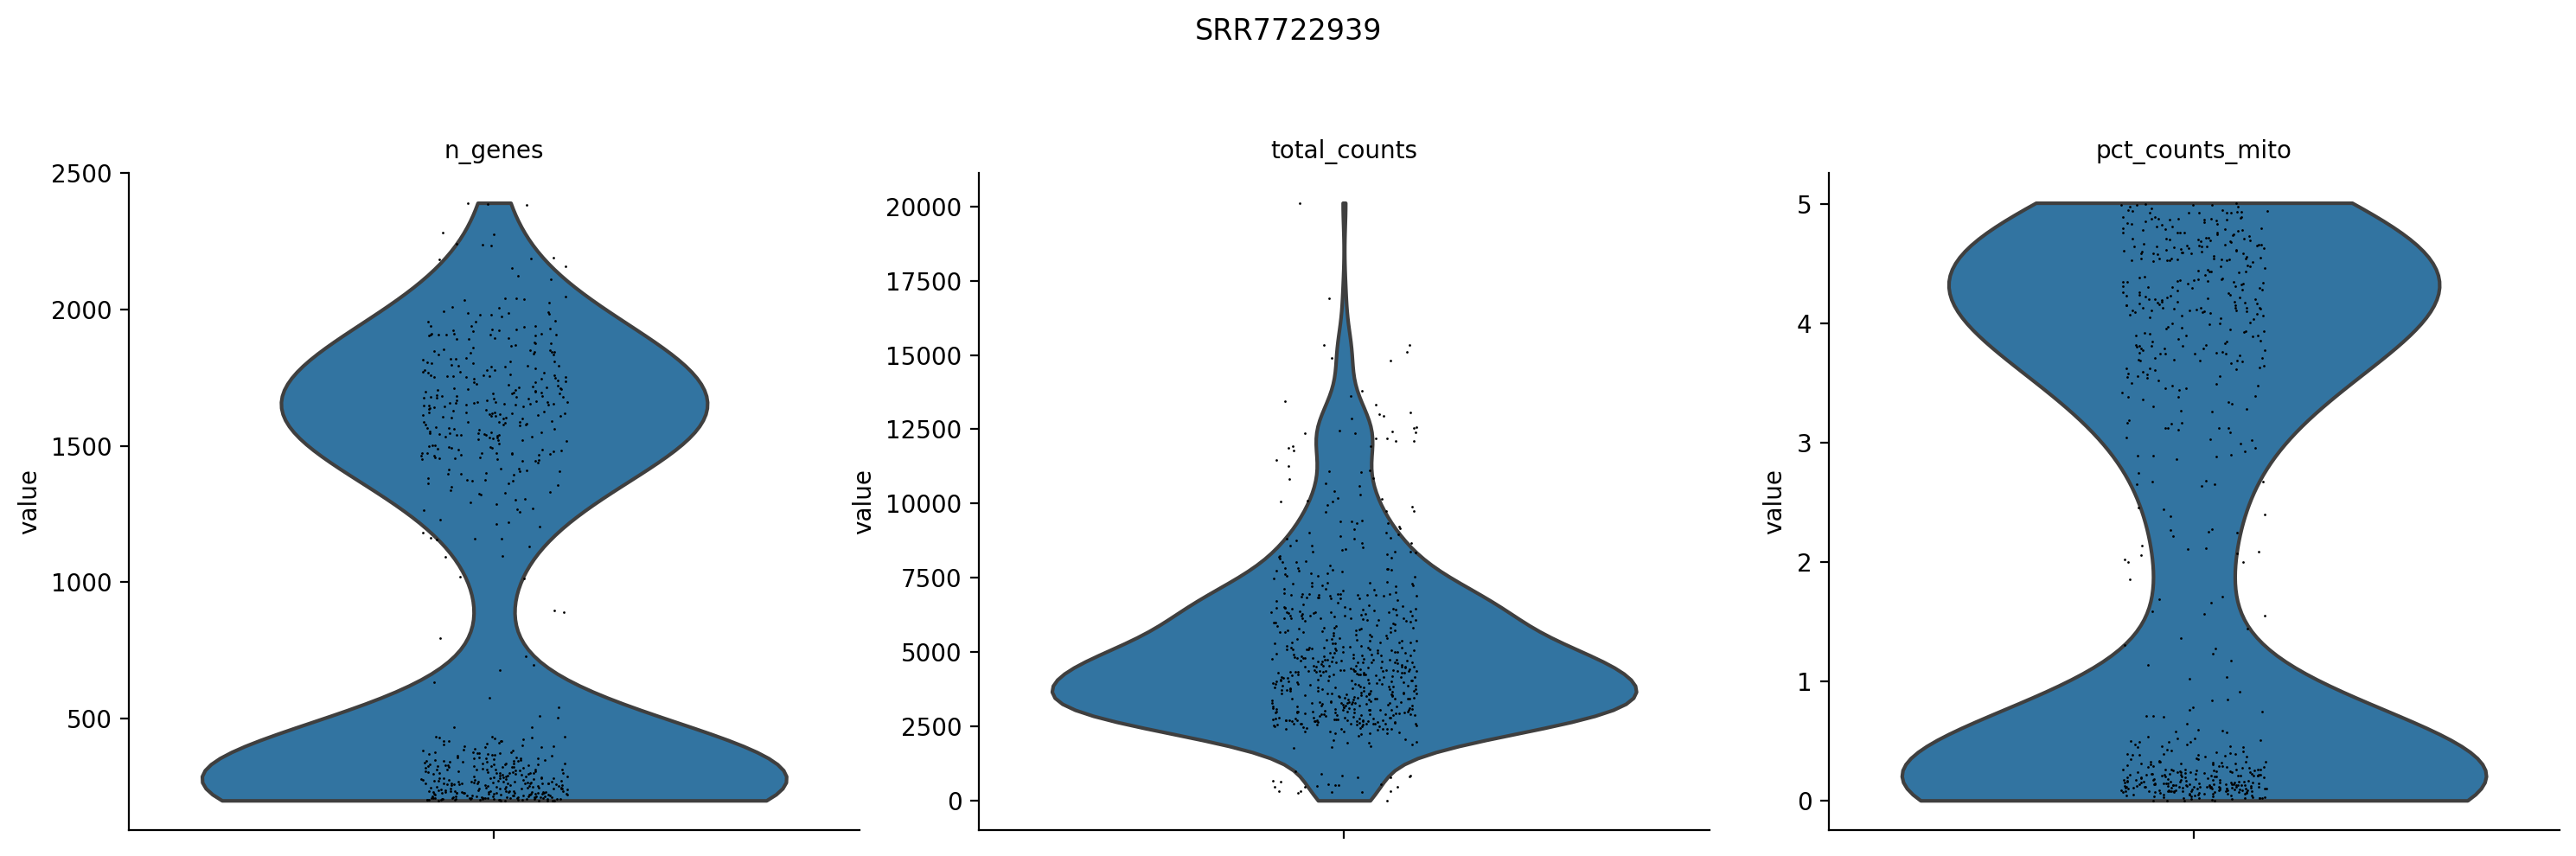

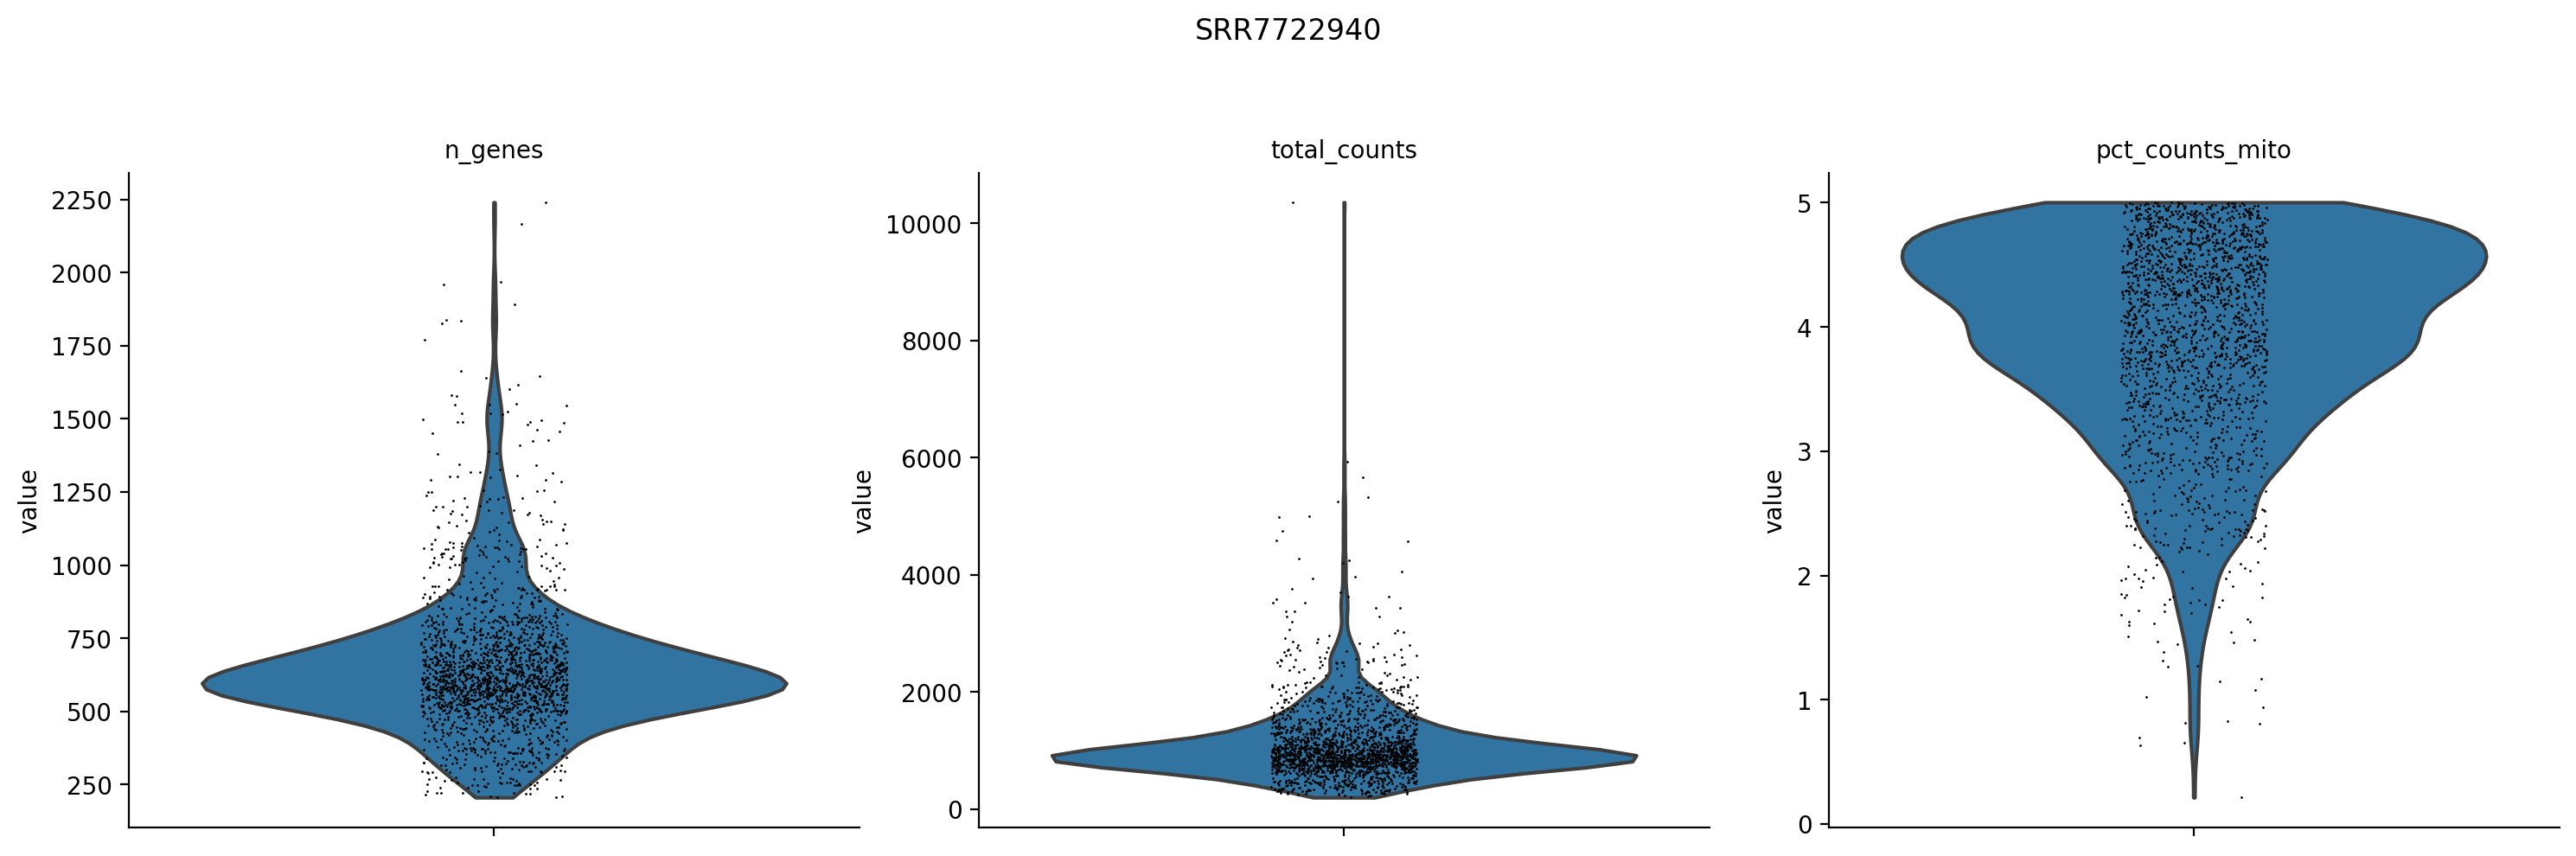

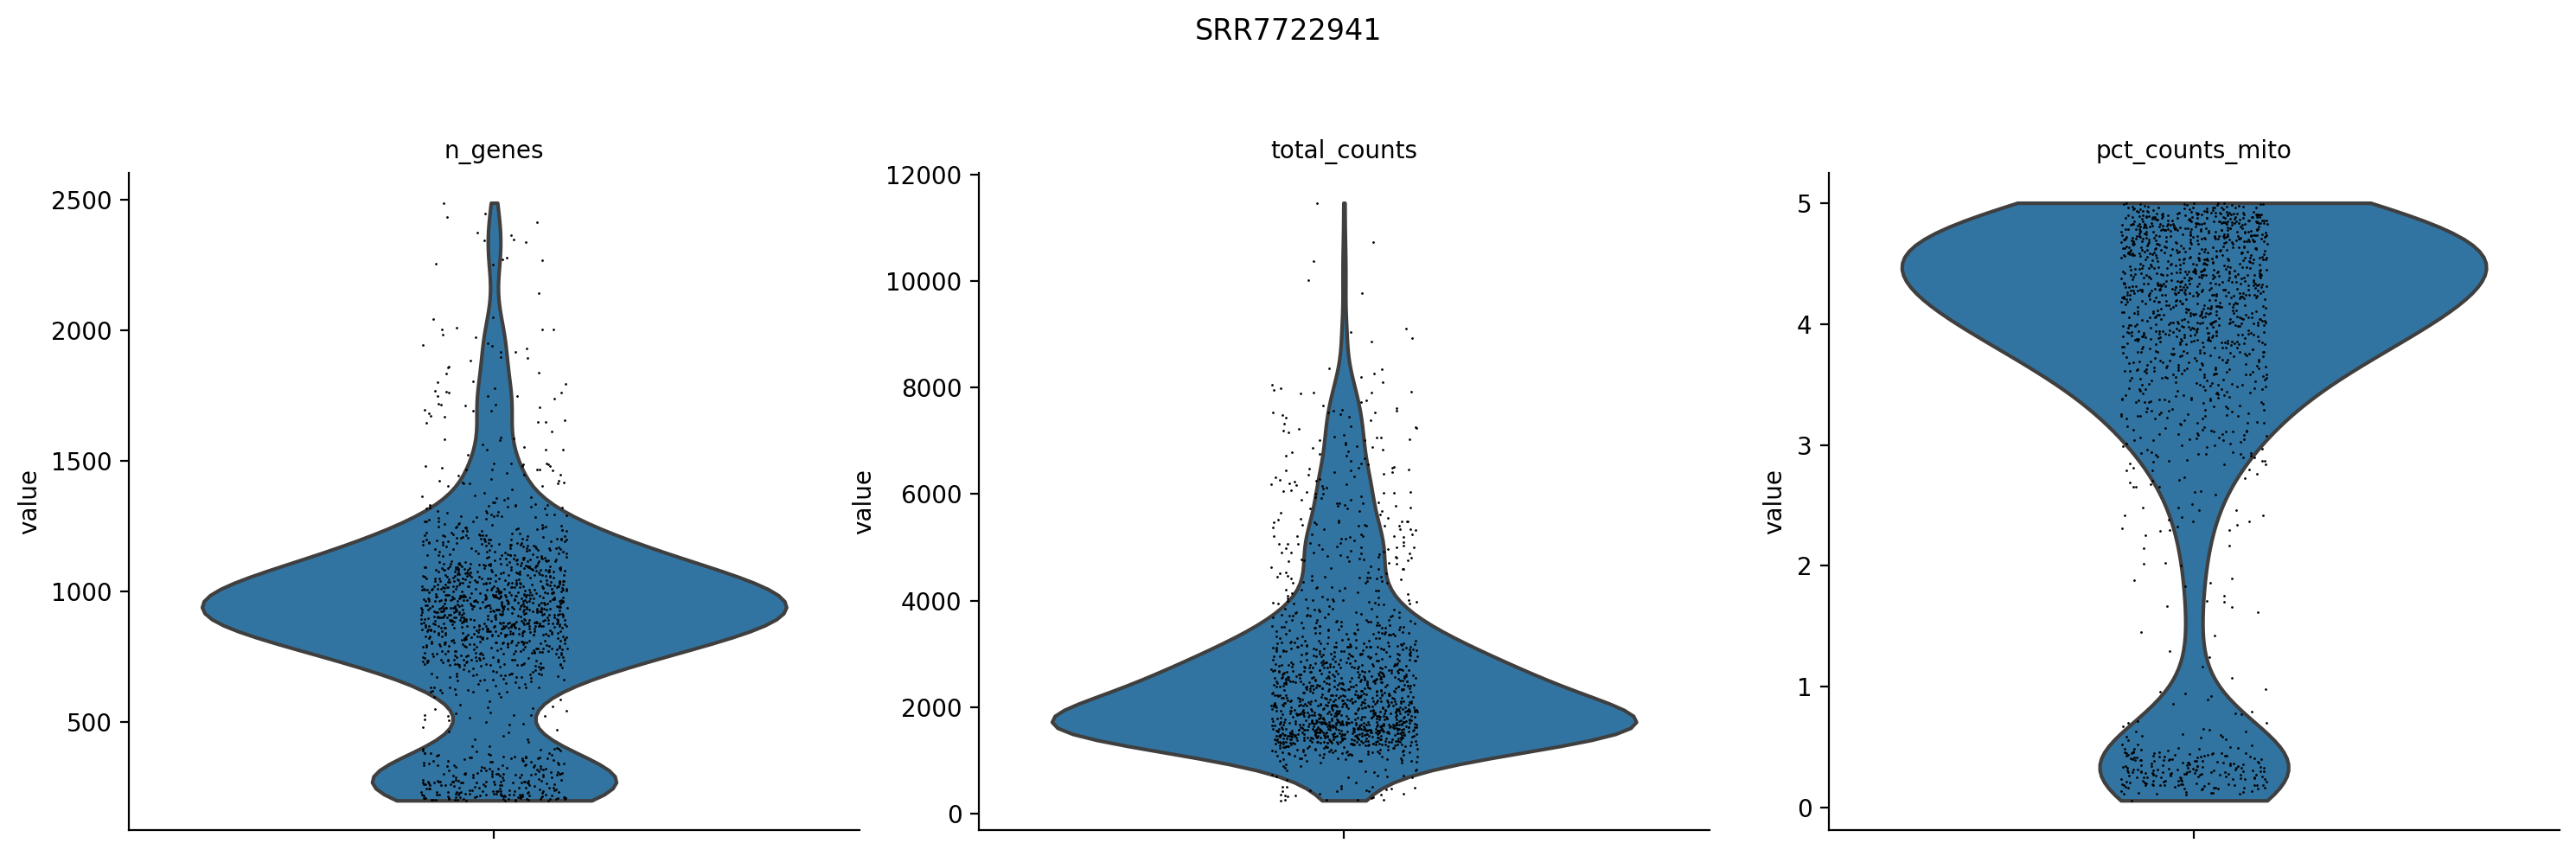

In [213]:
for sample, adata in adatas.items():
    ax = sc.pl.violin(adata, ['n_genes', 'total_counts', 'pct_counts_mito'], jitter=True, multi_panel=True, show=False)
    ax.fig.subplots_adjust(top=0.8);
    ax.fig.suptitle(sample)
    


## Aggregate Samples

Sequence depth normalization is not performed

In [216]:
for sample, adata in adatas.items():
    print(sample, adata.shape)

SRR7722938 (1065, 23555)
SRR7722939 (605, 20483)
SRR7722940 (1966, 22475)
SRR7722941 (1413, 22998)


In [223]:
adata_merged = anndata.concat(list(adatas.values()), join='outer', merge='same', label='sample')

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [228]:
adata_merged

AnnData object with n_obs × n_vars = 5049 × 28118
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_genes', 'sample'

## Normalization

In [229]:
sc.pp.normalize_total(adata_merged, target_sum=1e4)
sc.pp.log1p(adata_merged)

## Identify highly variable genes

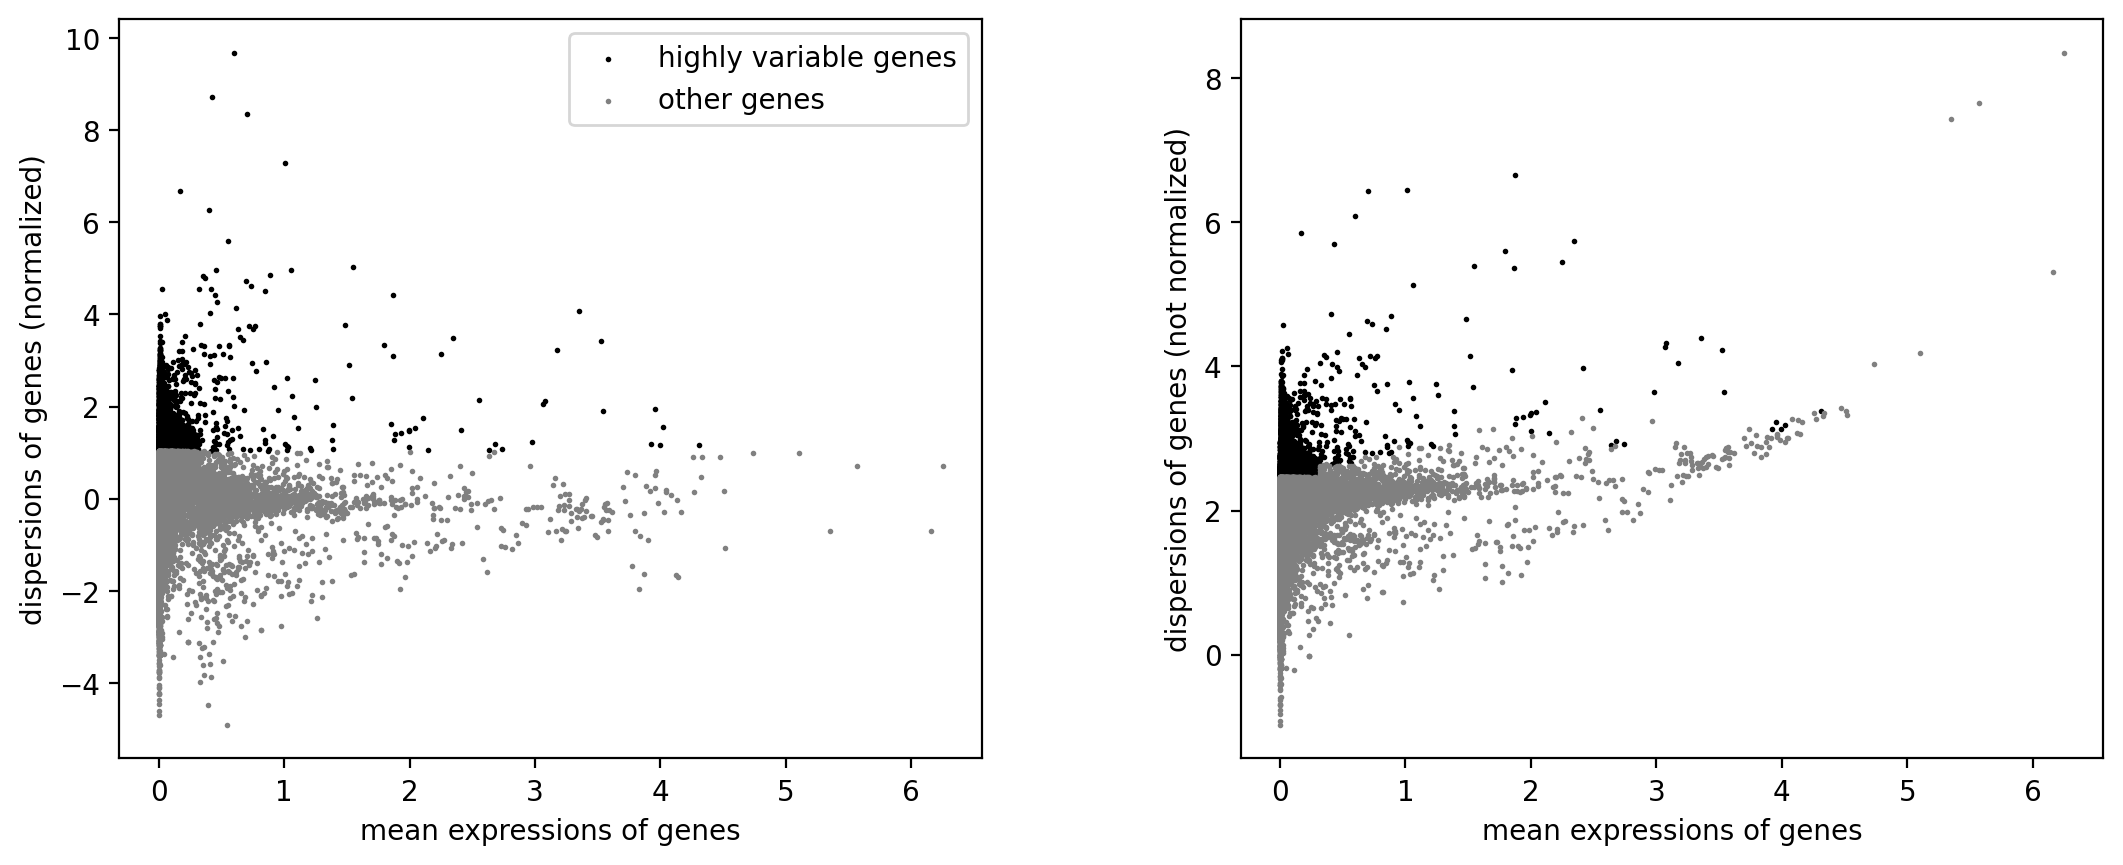

In [230]:
sc.pp.highly_variable_genes(adata_merged, min_mean=0.0125, max_mean=8, min_disp=0.5, n_top_genes=3000, n_bins=20, flavor="seurat")
sc.pl.highly_variable_genes(adata_merged)

### Freeze the data into .raw

Here, normalized data is freezed/seperated from further steps in adata.raw for later process

In [231]:
# freeze the normalized data
adata_merged.raw = adata_merged

### regress out outliers and scale the data

In [235]:
sc.pp.regress_out(adata_merged, ['total_counts', 'pct_counts_mito'])
sc.pp.scale(adata_merged, max_value=10)

## Clustering

### PCA and choice of PCs

In [244]:
sc.tl.pca(adata_merged, svd_solver='arpack', n_comps=40)

In [248]:
print(adata_merged.uns['pca']['variance_ratio'][0:10].sum())

0.07158420470521529


<Axes: ylabel='Proportion'>

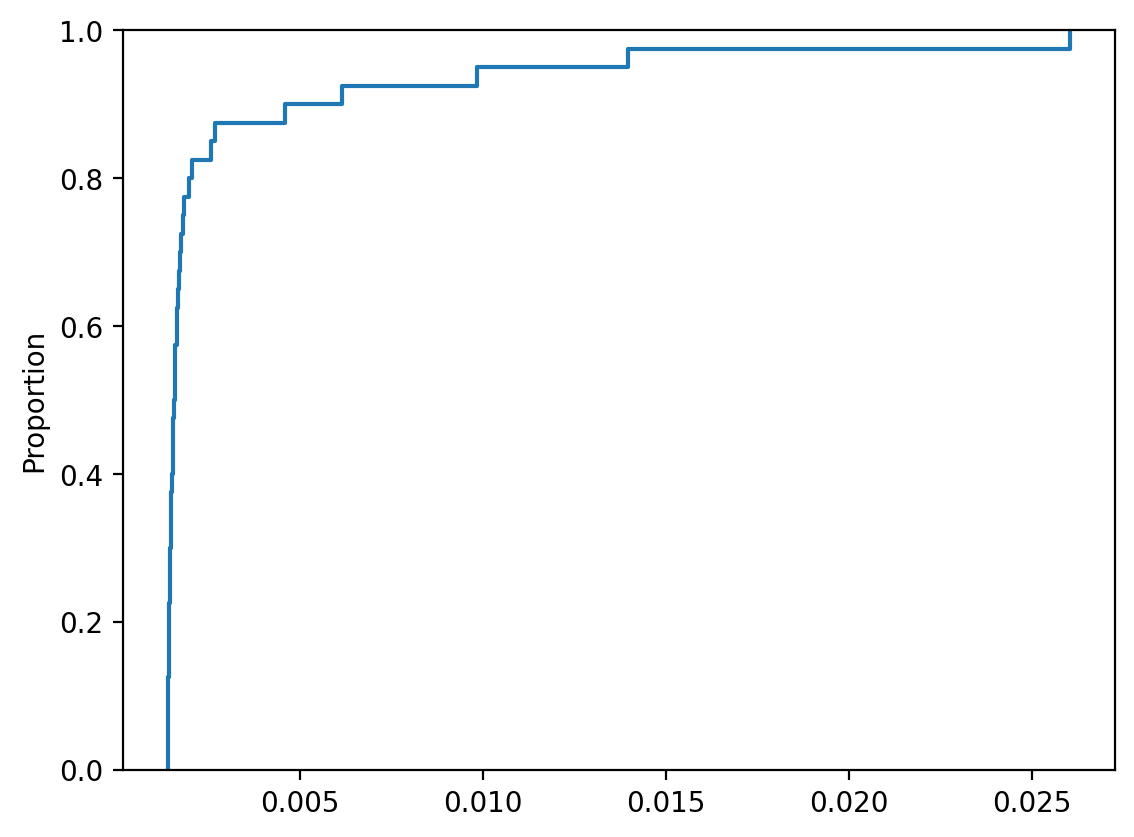

In [260]:
sns.ecdfplot(adata_merged.uns['pca']['variance_ratio'])

### PCA Overview

A general look of first 10 PCs

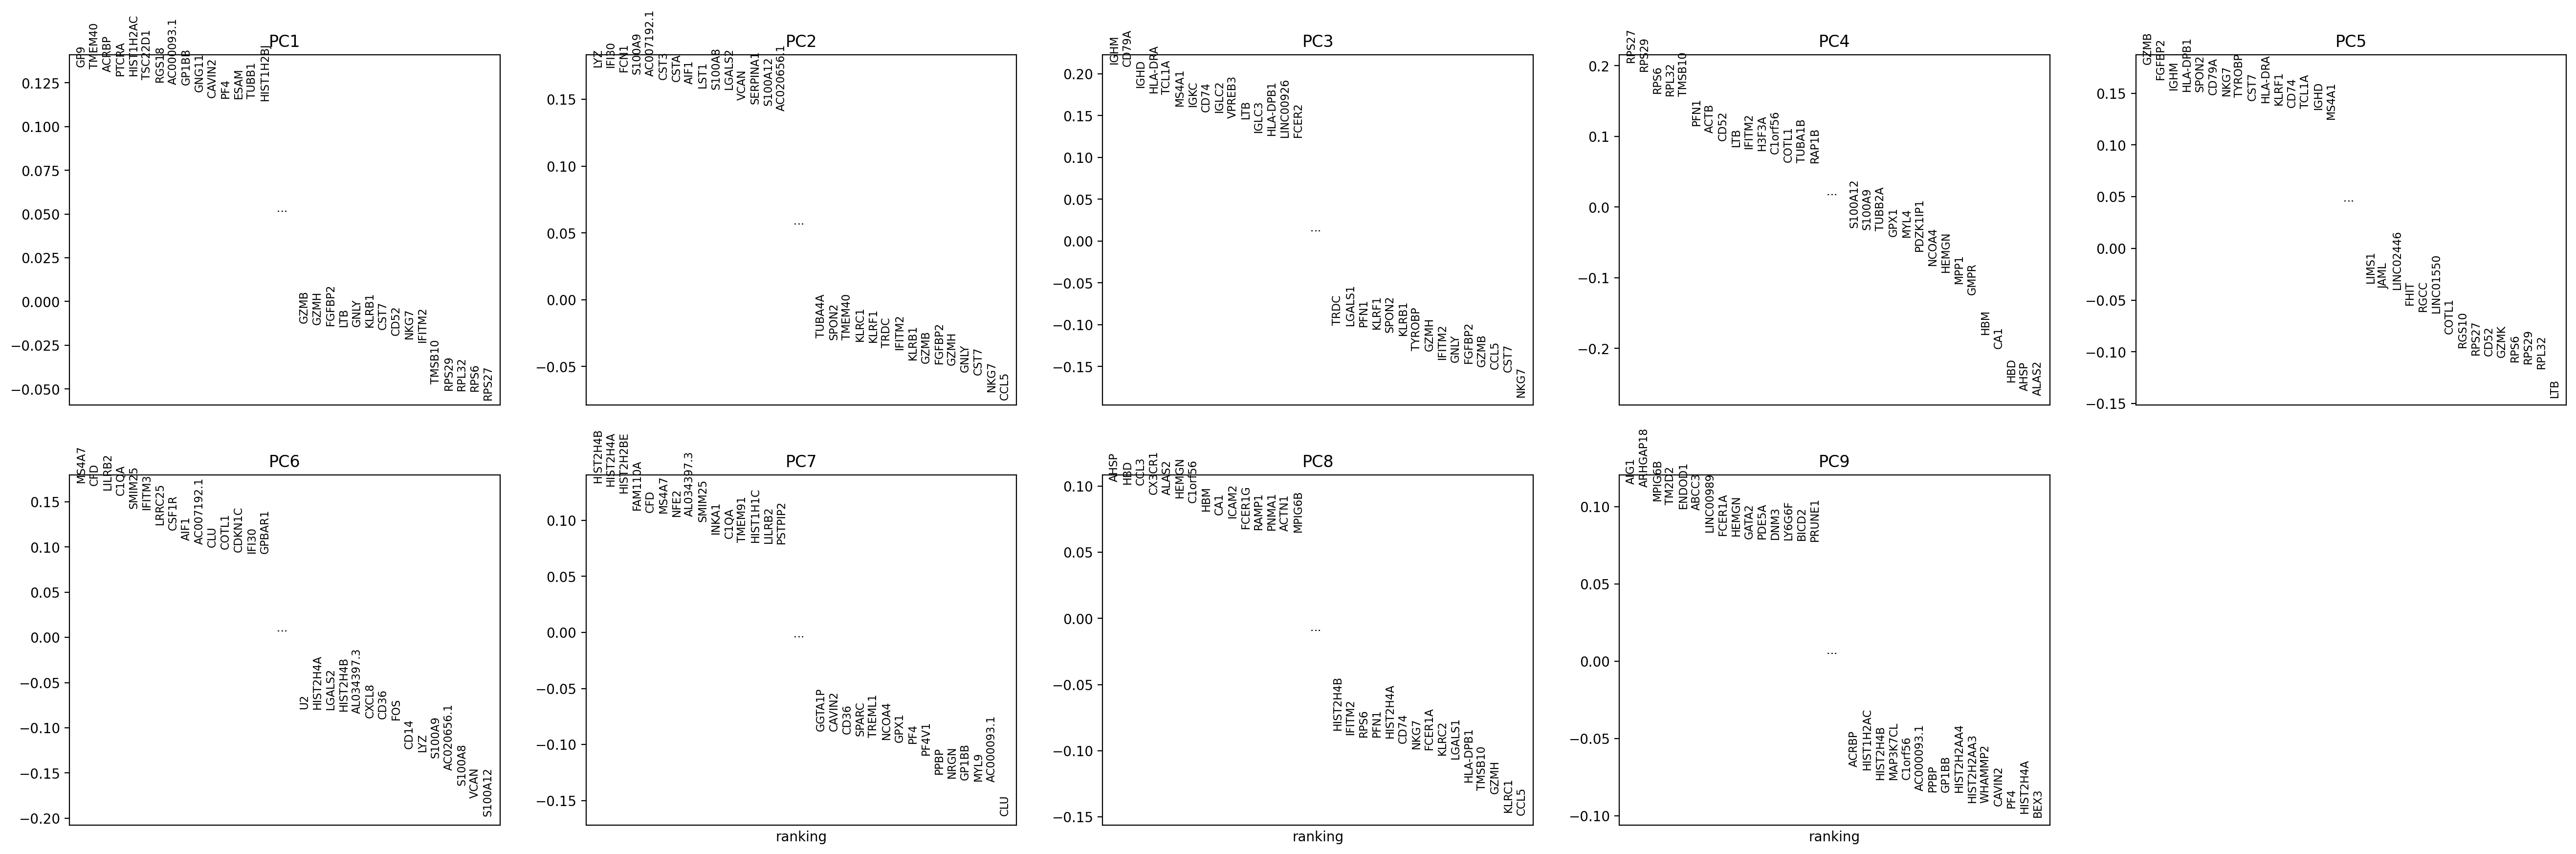

In [262]:
sc.pl.pca_loadings(adata_merged, list(range(1,10)))

The visualizatoin of variance ratio of PCs below indicates that the first 10 PCs are chosen for downstream analysis

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


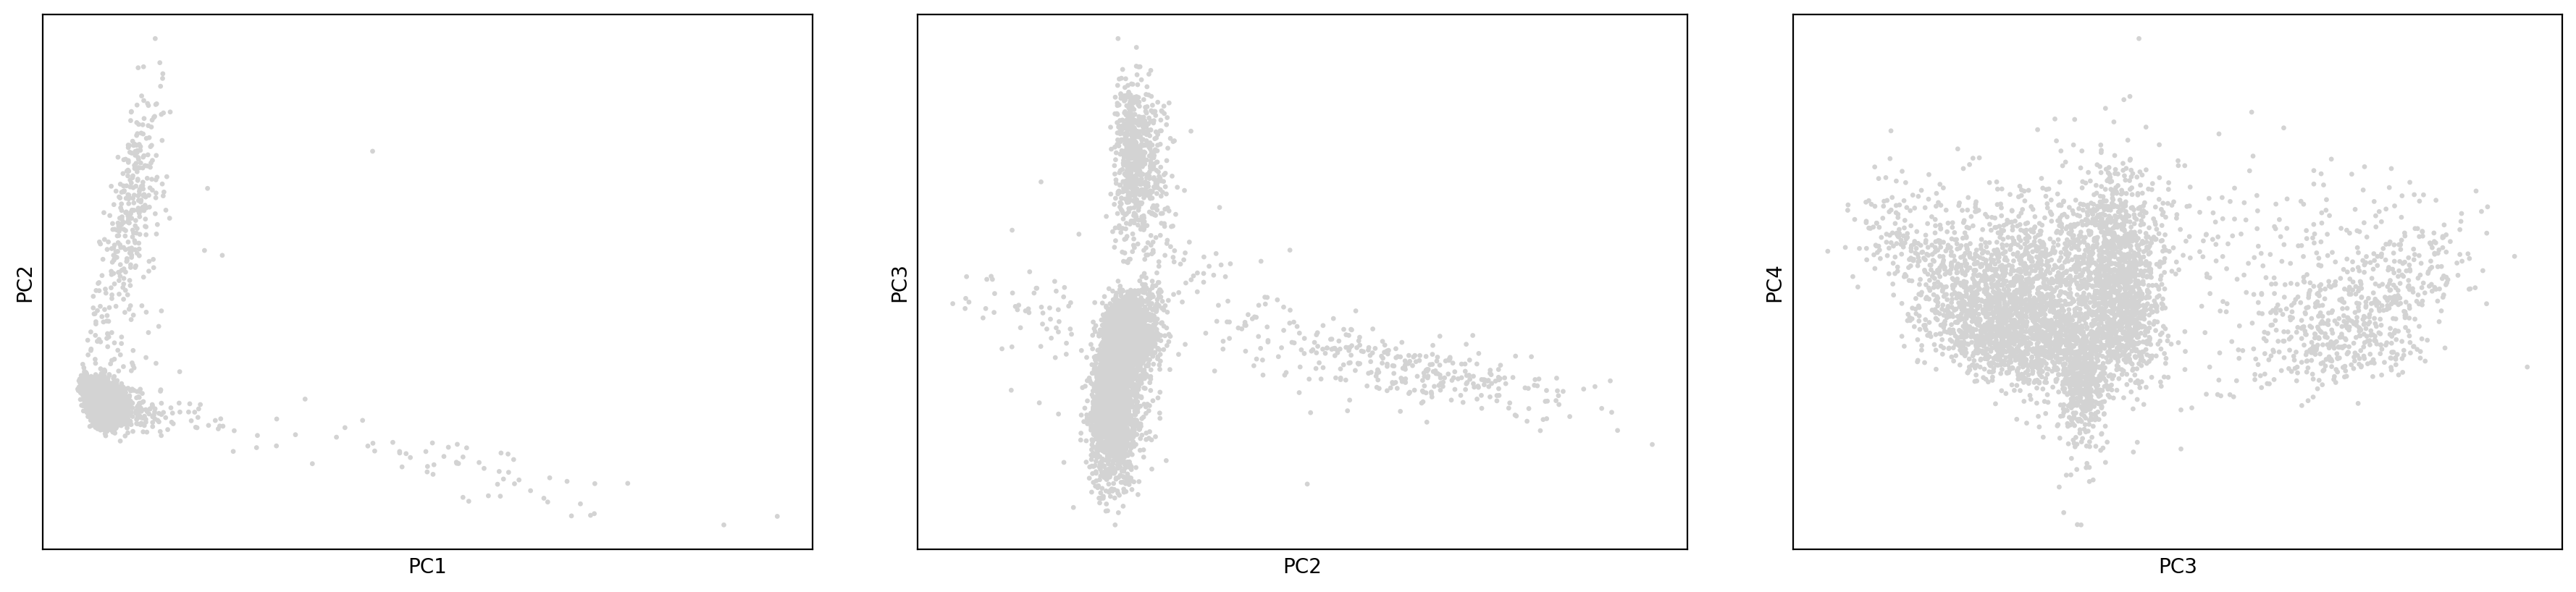

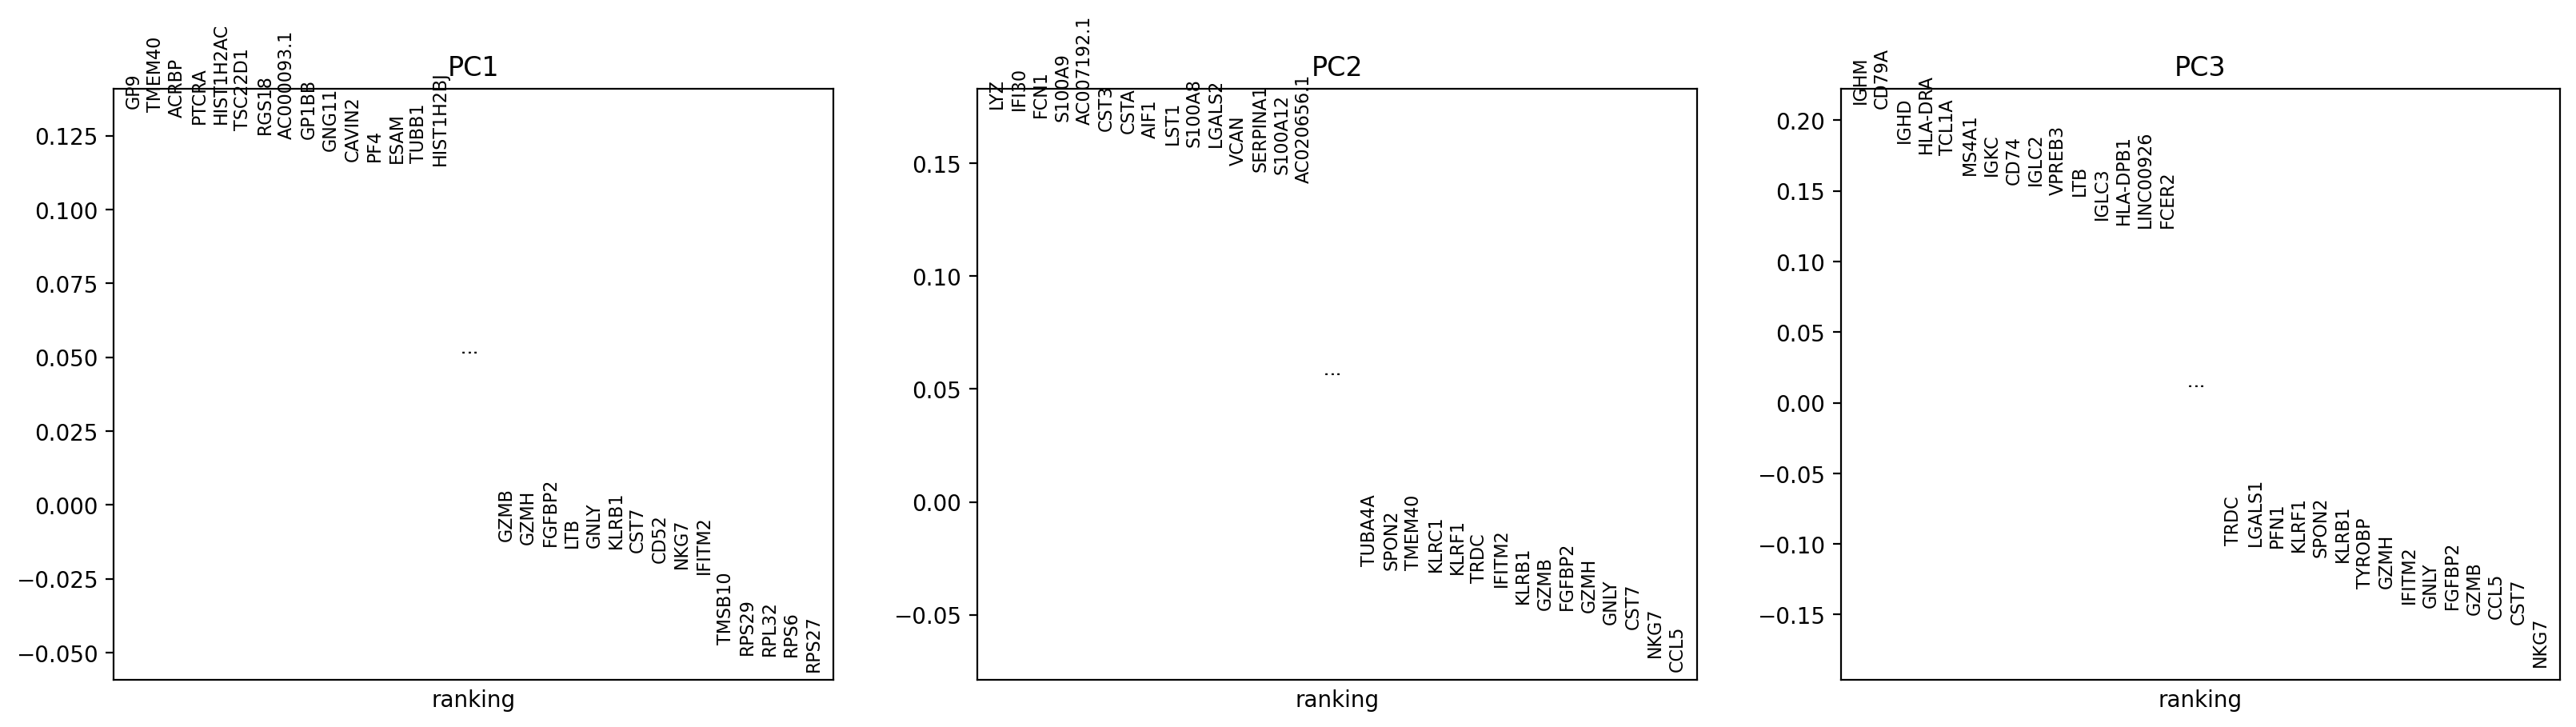

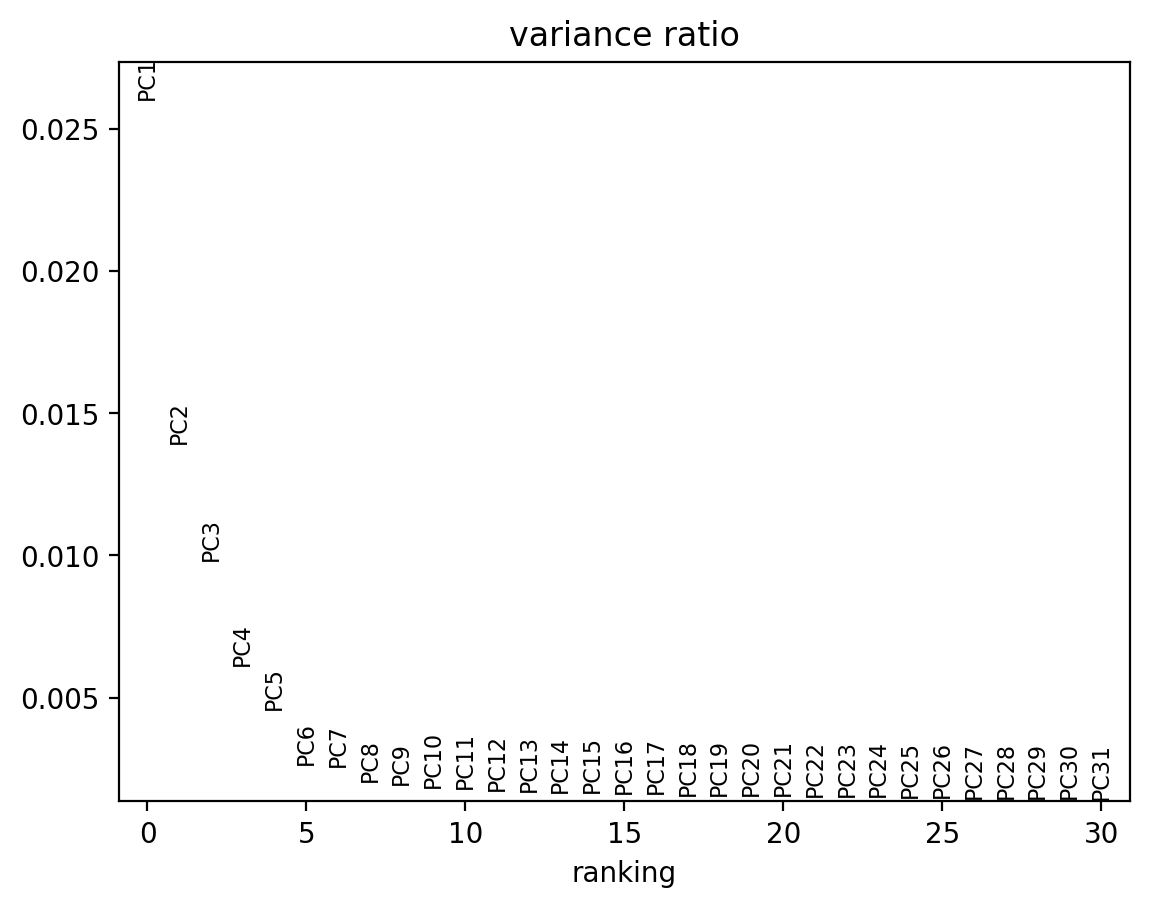

In [267]:
sc.pl.pca_overview(adata_merged, components=['1,2', '2,3', '3,4'])

### Louvain clustering and t-SNE visualization

In [285]:
# Louvain clustering
# Cluster the cells using Louvain clustering

sc.pp.neighbors(adata_merged, n_neighbors=40, n_pcs=10, knn=True)
sc.tl.louvain(adata_merged, resolution=0.8)

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


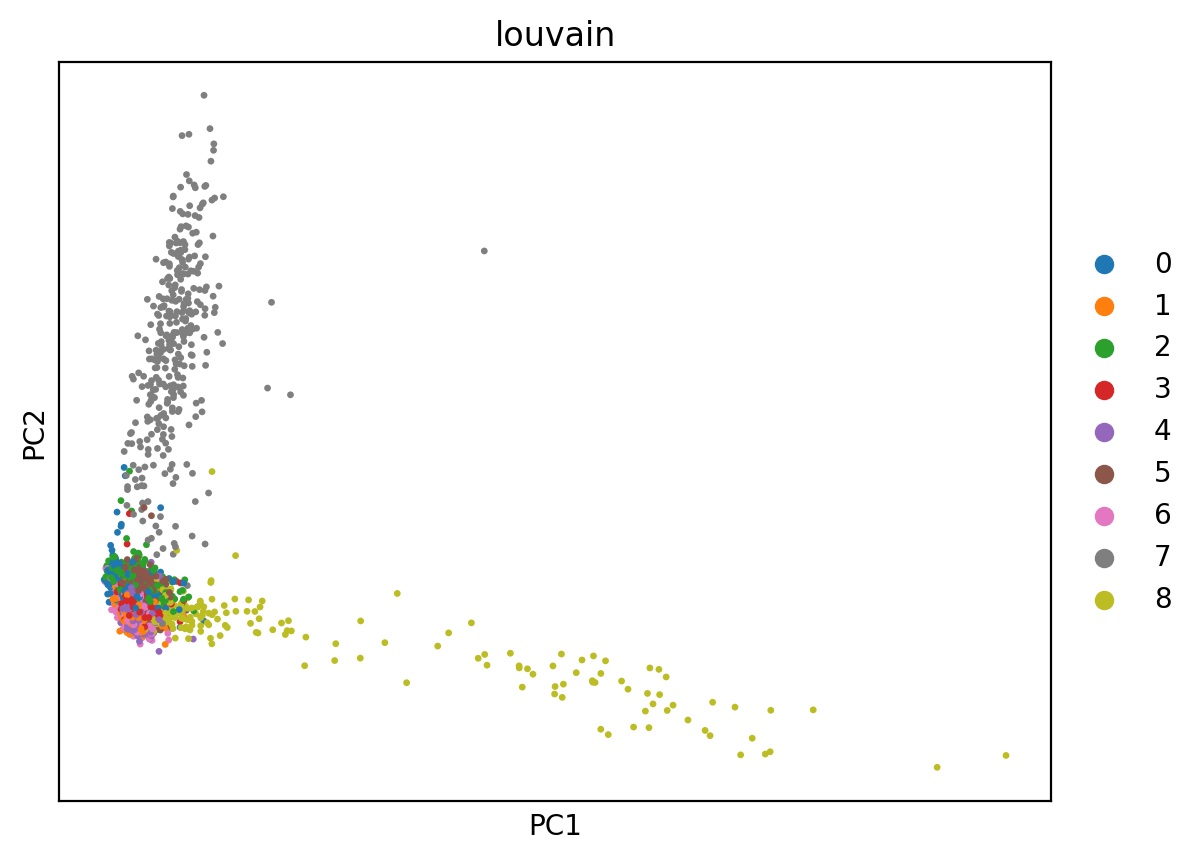

In [286]:
# Perform PCA and plot the projection to the first two dimensions, with points colored according to the Louvain clusters.
# fig, axe = plt.subplots(1, 2, figsize=(10, 7))
# for adata, ax in zip(adatas, axe):
#     sc.pl.pca(adata, color='louvain', show=False, ax=ax)
sc.pl.pca(adata_merged, color='louvain')

In [287]:
# perform t-sne on top 10 pcs
sc.tl.tsne(adata_merged, n_pcs=10)

### Check batch effect

From the t-SNE graph, no apparent batch effect observed

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


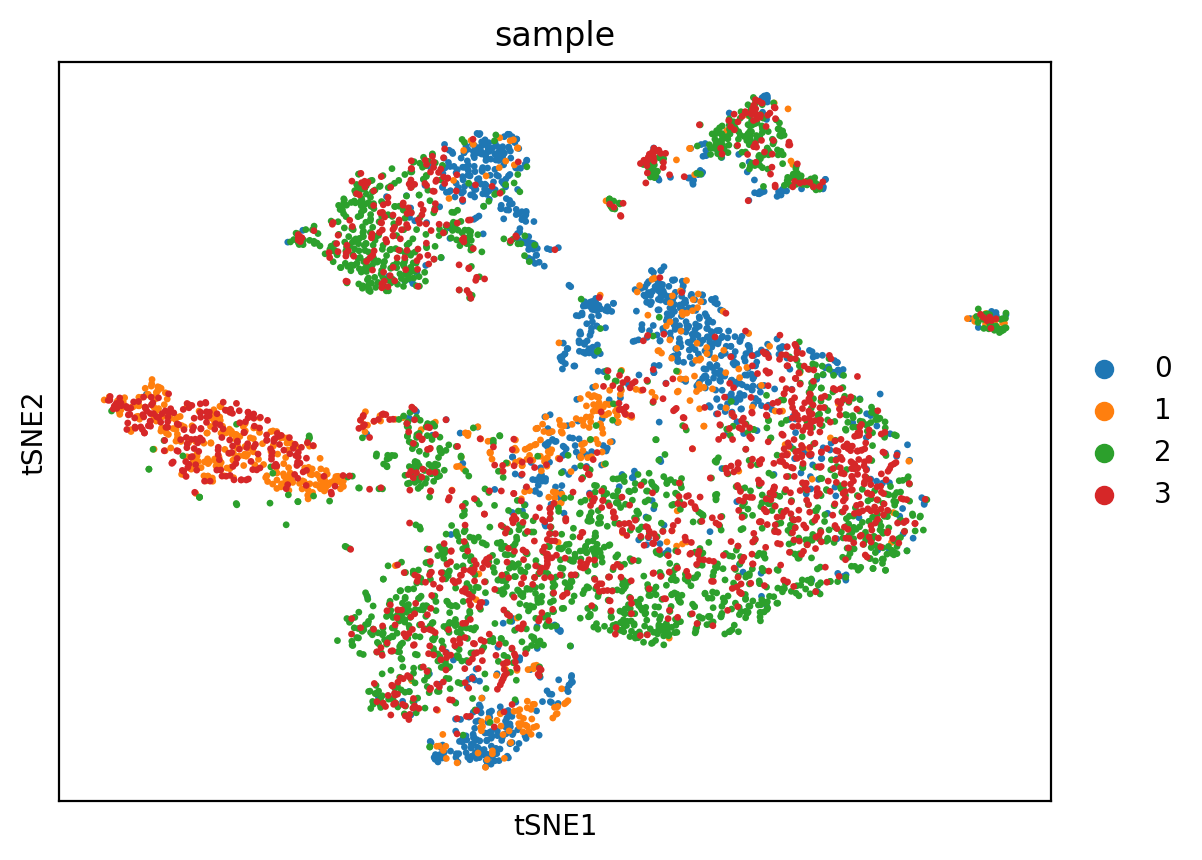

In [288]:
# t-sne visualization 
# check batch effect
sc.pl.tsne(adata_merged, color='sample')

### t-SNE Visualization

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


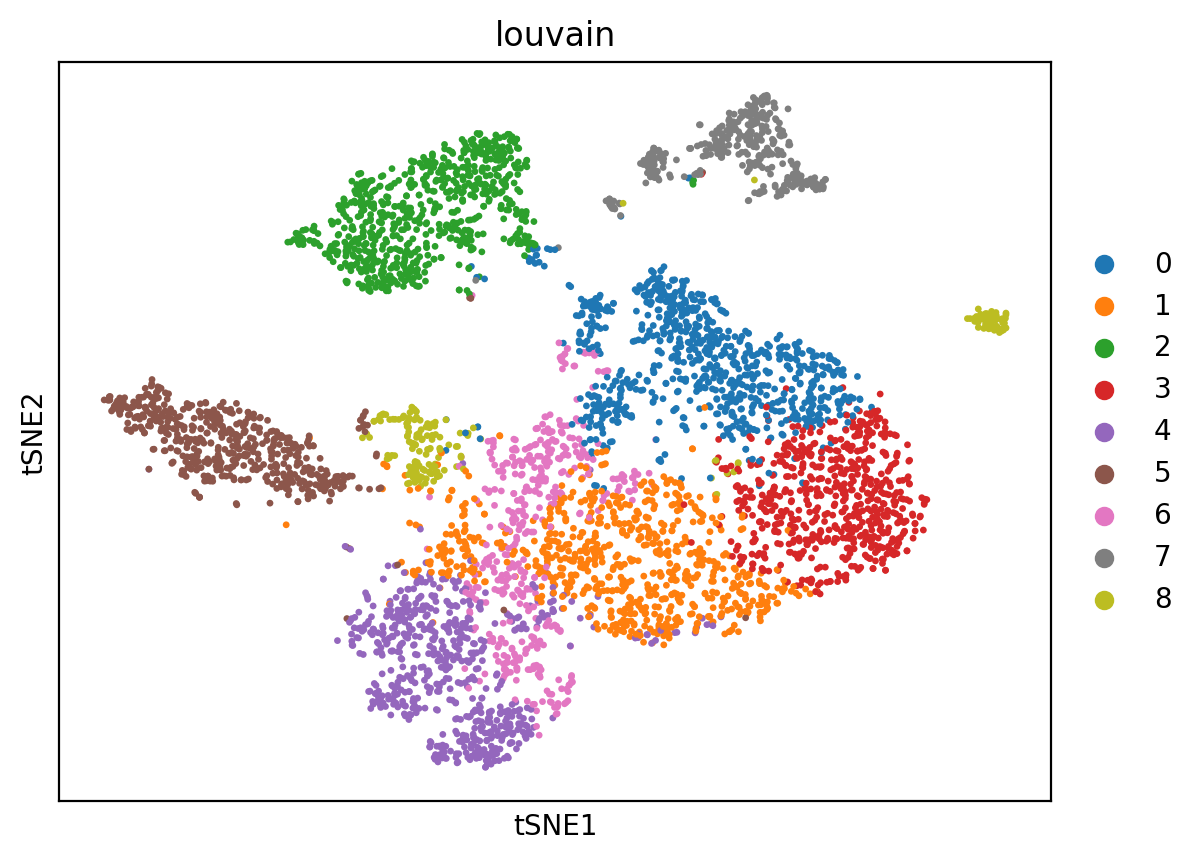

In [386]:
sc.pl.tsne(adata_merged, color=['louvain'])

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-

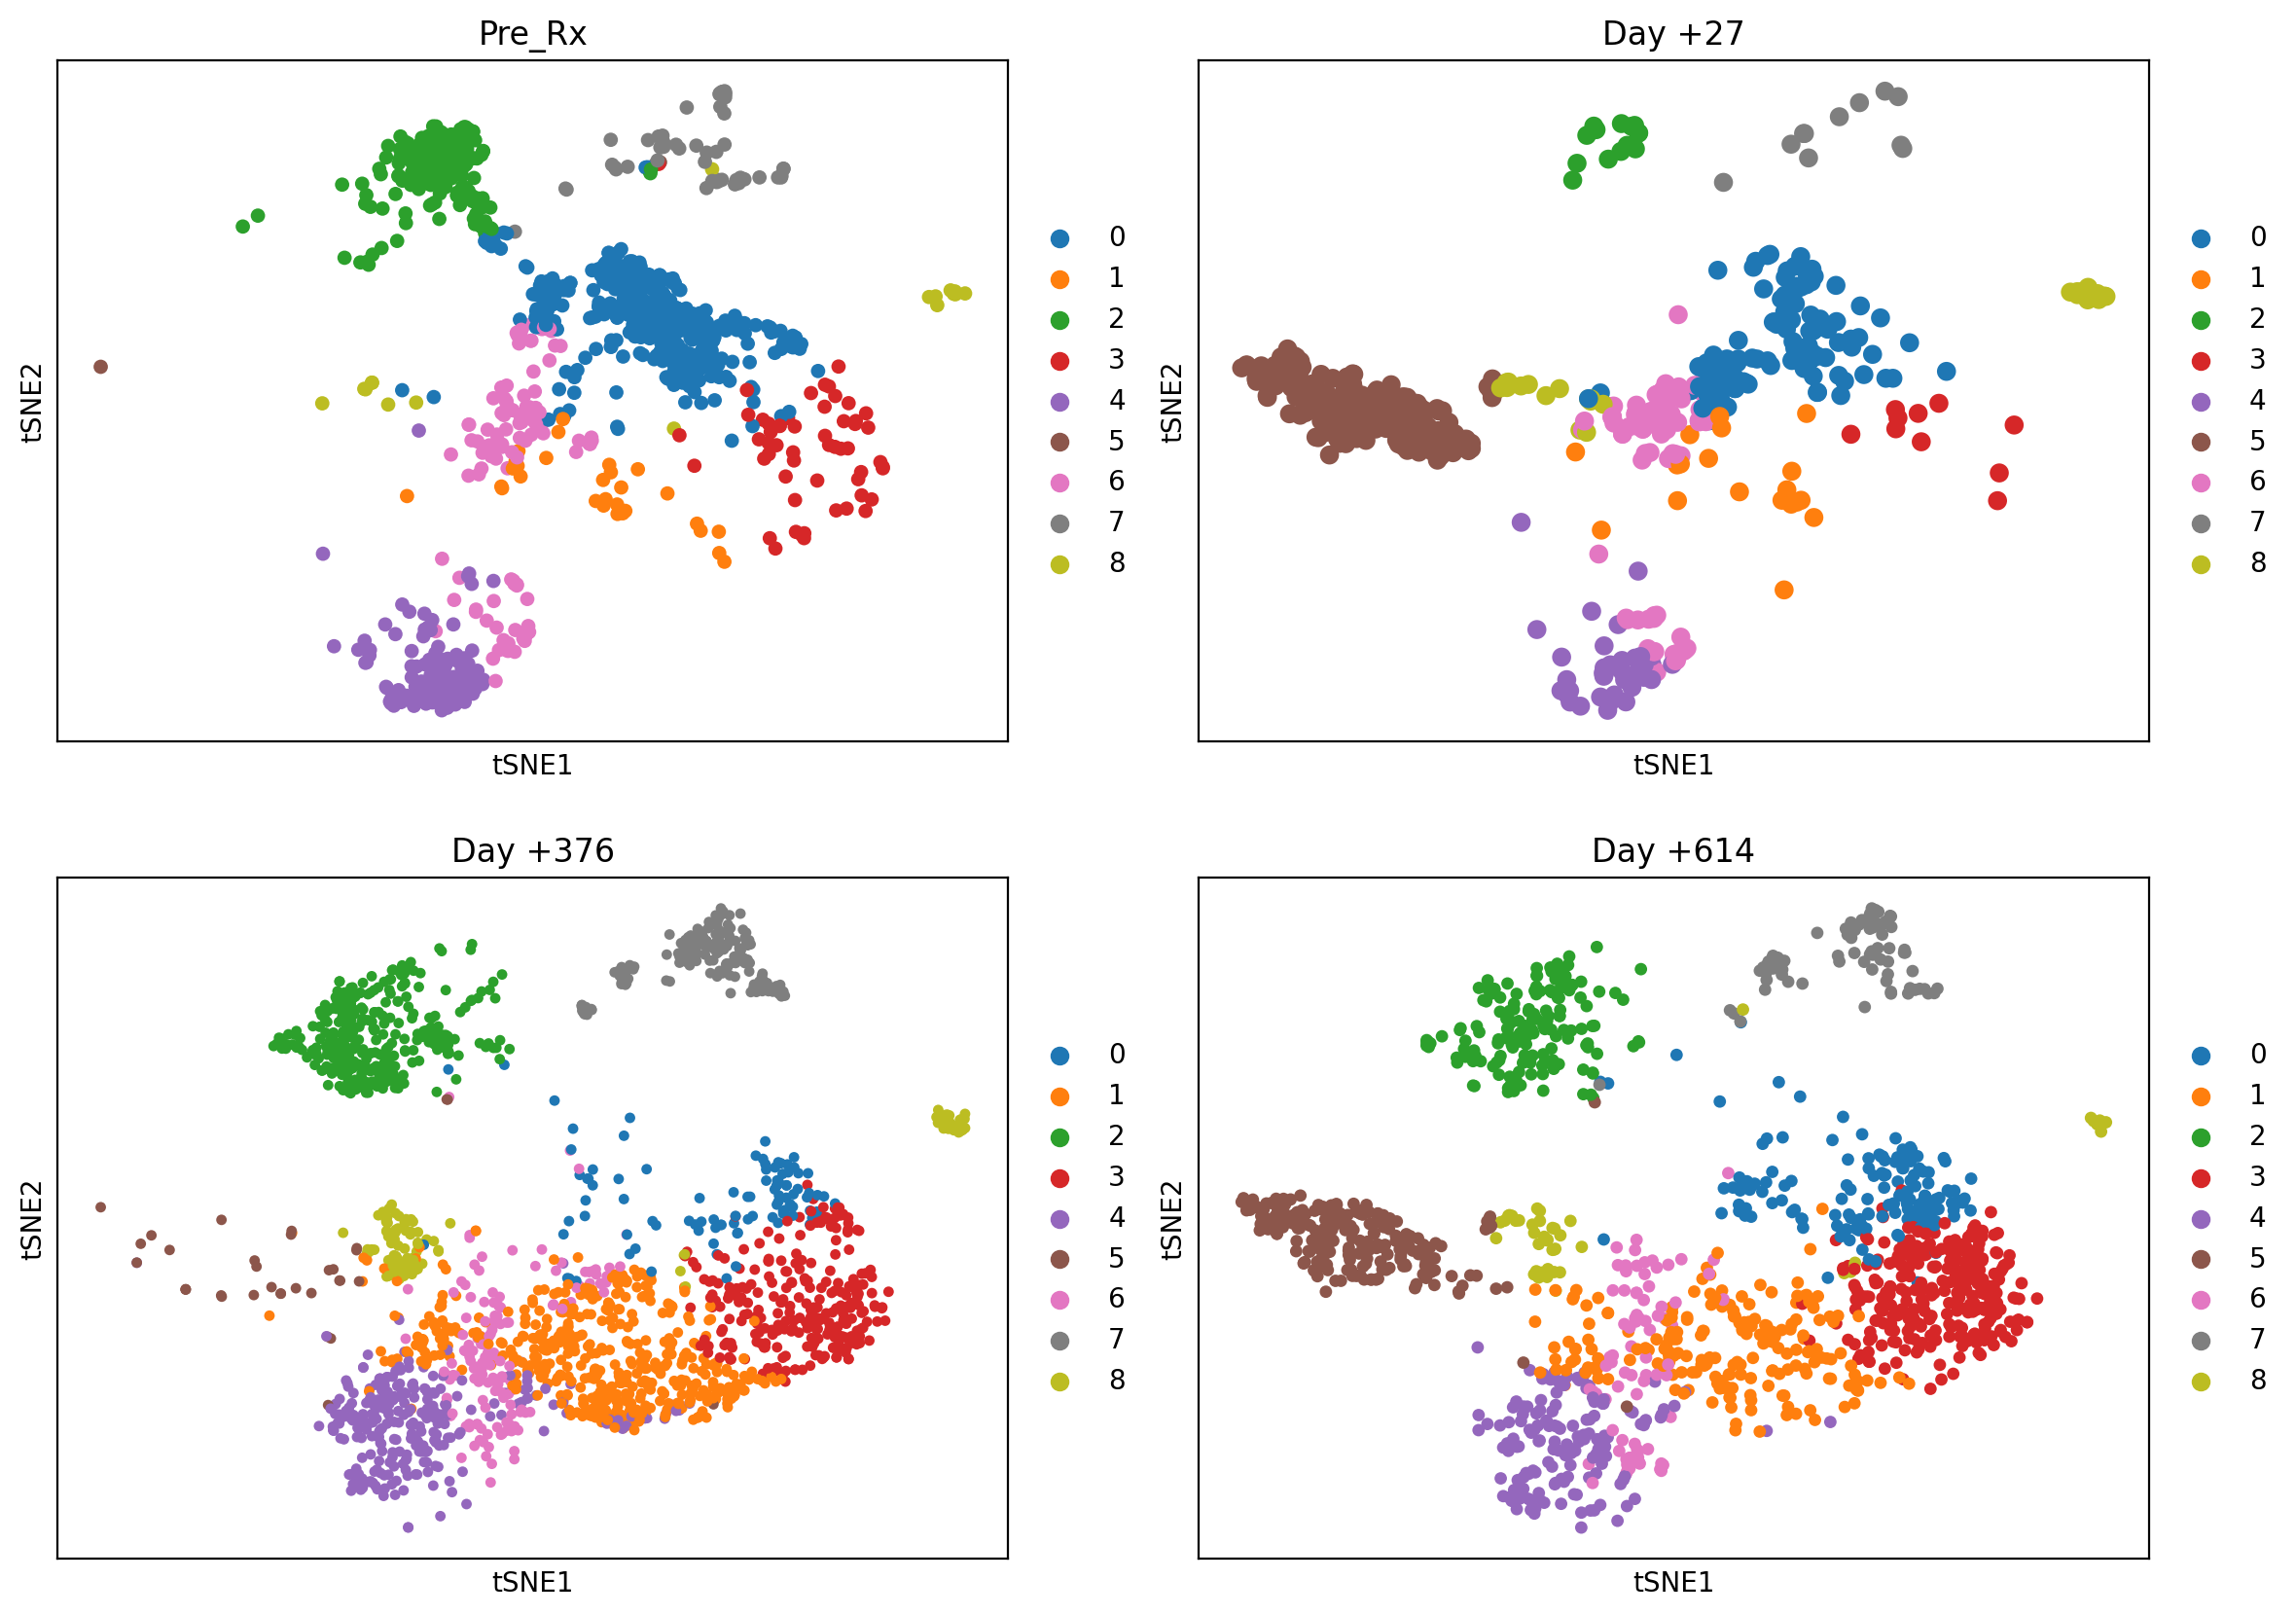

In [404]:
titles = ['Pre_Rx', 'Day +27', 'Day +376', 'Day +614']
fig, axe = plt.subplots(2, 2, figsize=(10,10))
for i, ax, t in zip(range(0,4), axe.flatten(), titles):
    f = adata_merged.obs['sample'] == str(i)
    sc.pl.tsne(adata_merged[f], color='louvain', ax=ax, show=False)
    ax.set_title(t)
plt.subplots_adjust(right=1.2)

In [387]:
adata_merged.obs['sample']

barcode
AAACCTGAGCGAAGGG    0
AAACCTGCACCAGCAC    0
AAACCTGCACTACAGT    0
AAACCTGGTAAGGATT    0
AAACCTGGTTCCACTC    0
                   ..
TTTGGTTTCTCGGACG    3
TTTGTCAAGCAGATCG    3
TTTGTCAAGCGAGAAA    3
TTTGTCAAGGAATTAC    3
TTTGTCATCATTGCGA    3
Name: sample, Length: 5049, dtype: category
Categories (4, object): ['0', '1', '2', '3']

## Cluster Annotation

### load know marker genes and corresponding cell type map

In [295]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    "ID2-hi myeloid prog": [
        "CD14",
        "ID2",
        "VCAN",
        "S100A9",
        "CLEC12A",
        "KLF4",
        "PLAUR",
    ],
    "cDC1": ["CLEC9A", "CADM1"],
    "cDC2": [
        "CST3",
        "COTL1",
        "LYZ",
        "DMXL2",
        "CLEC10A",
        "FCER1A",
    ],  # Note: DMXL2 should be negative
    "Normoblast": ["SLC4A1", "SLC25A37", "HBB", "HBA2", "HBA1", "TFRC"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    "Proerythroblast": [
        "CDK6",
        "SYNGR1",
        "HBM",
        "GYPA",
    ],  # Note HBM and GYPA are negative markers
    "NK": ["GNLY", "NKG7", "CD247", "GRIK4", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Lymph prog": [
        "VPREB1",
        "MME",
        "EBF1",
        "SSBP2",
        "BACH2",
        "CD79B",
        "IGHM",
        "PAX5",
        "PRKCE",
        "DNTT",
        "IGLL1",
    ],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    "B1 B": [
        "MS4A1",
        "SSPN",
        "ITGB1",
        "EPHA4",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "CD38",
        "XBP1",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
        "ZNF215",
    ],  # Note IGHD and IGHM are negative markers
    "Transitional B": ["MME", "CD38", "CD24", "ACSM3", "MSI2"],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    "Plasmablast": ["XBP1", "RF4", "PRDM1", "PAX5"],  # Note PAX5 is a negative marker
    "CD4+ T activated": ["CD4", "IL7R", "TRBC2", "ITGB1"],
    "CD4+ T naive": ["CD4", "IL7R", "TRBC2", "CCR7"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T activation": ["CD69", "CD38"],  # CD69 much better marker!
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
    "G/M prog": ["MPO", "BCL2", "KCNQ5", "CSF3R"],
    "HSC": ["NRIP1", "MECOM", "PROM1", "NKAIN2", "CD34"],
    "MK/E prog": [
        "ZNF385D",
        "ITGA2B",
        "RYR3",
        "PLCB1",
    ],  # Note PLCB1 is a negative marker
}

### Find Marker genes

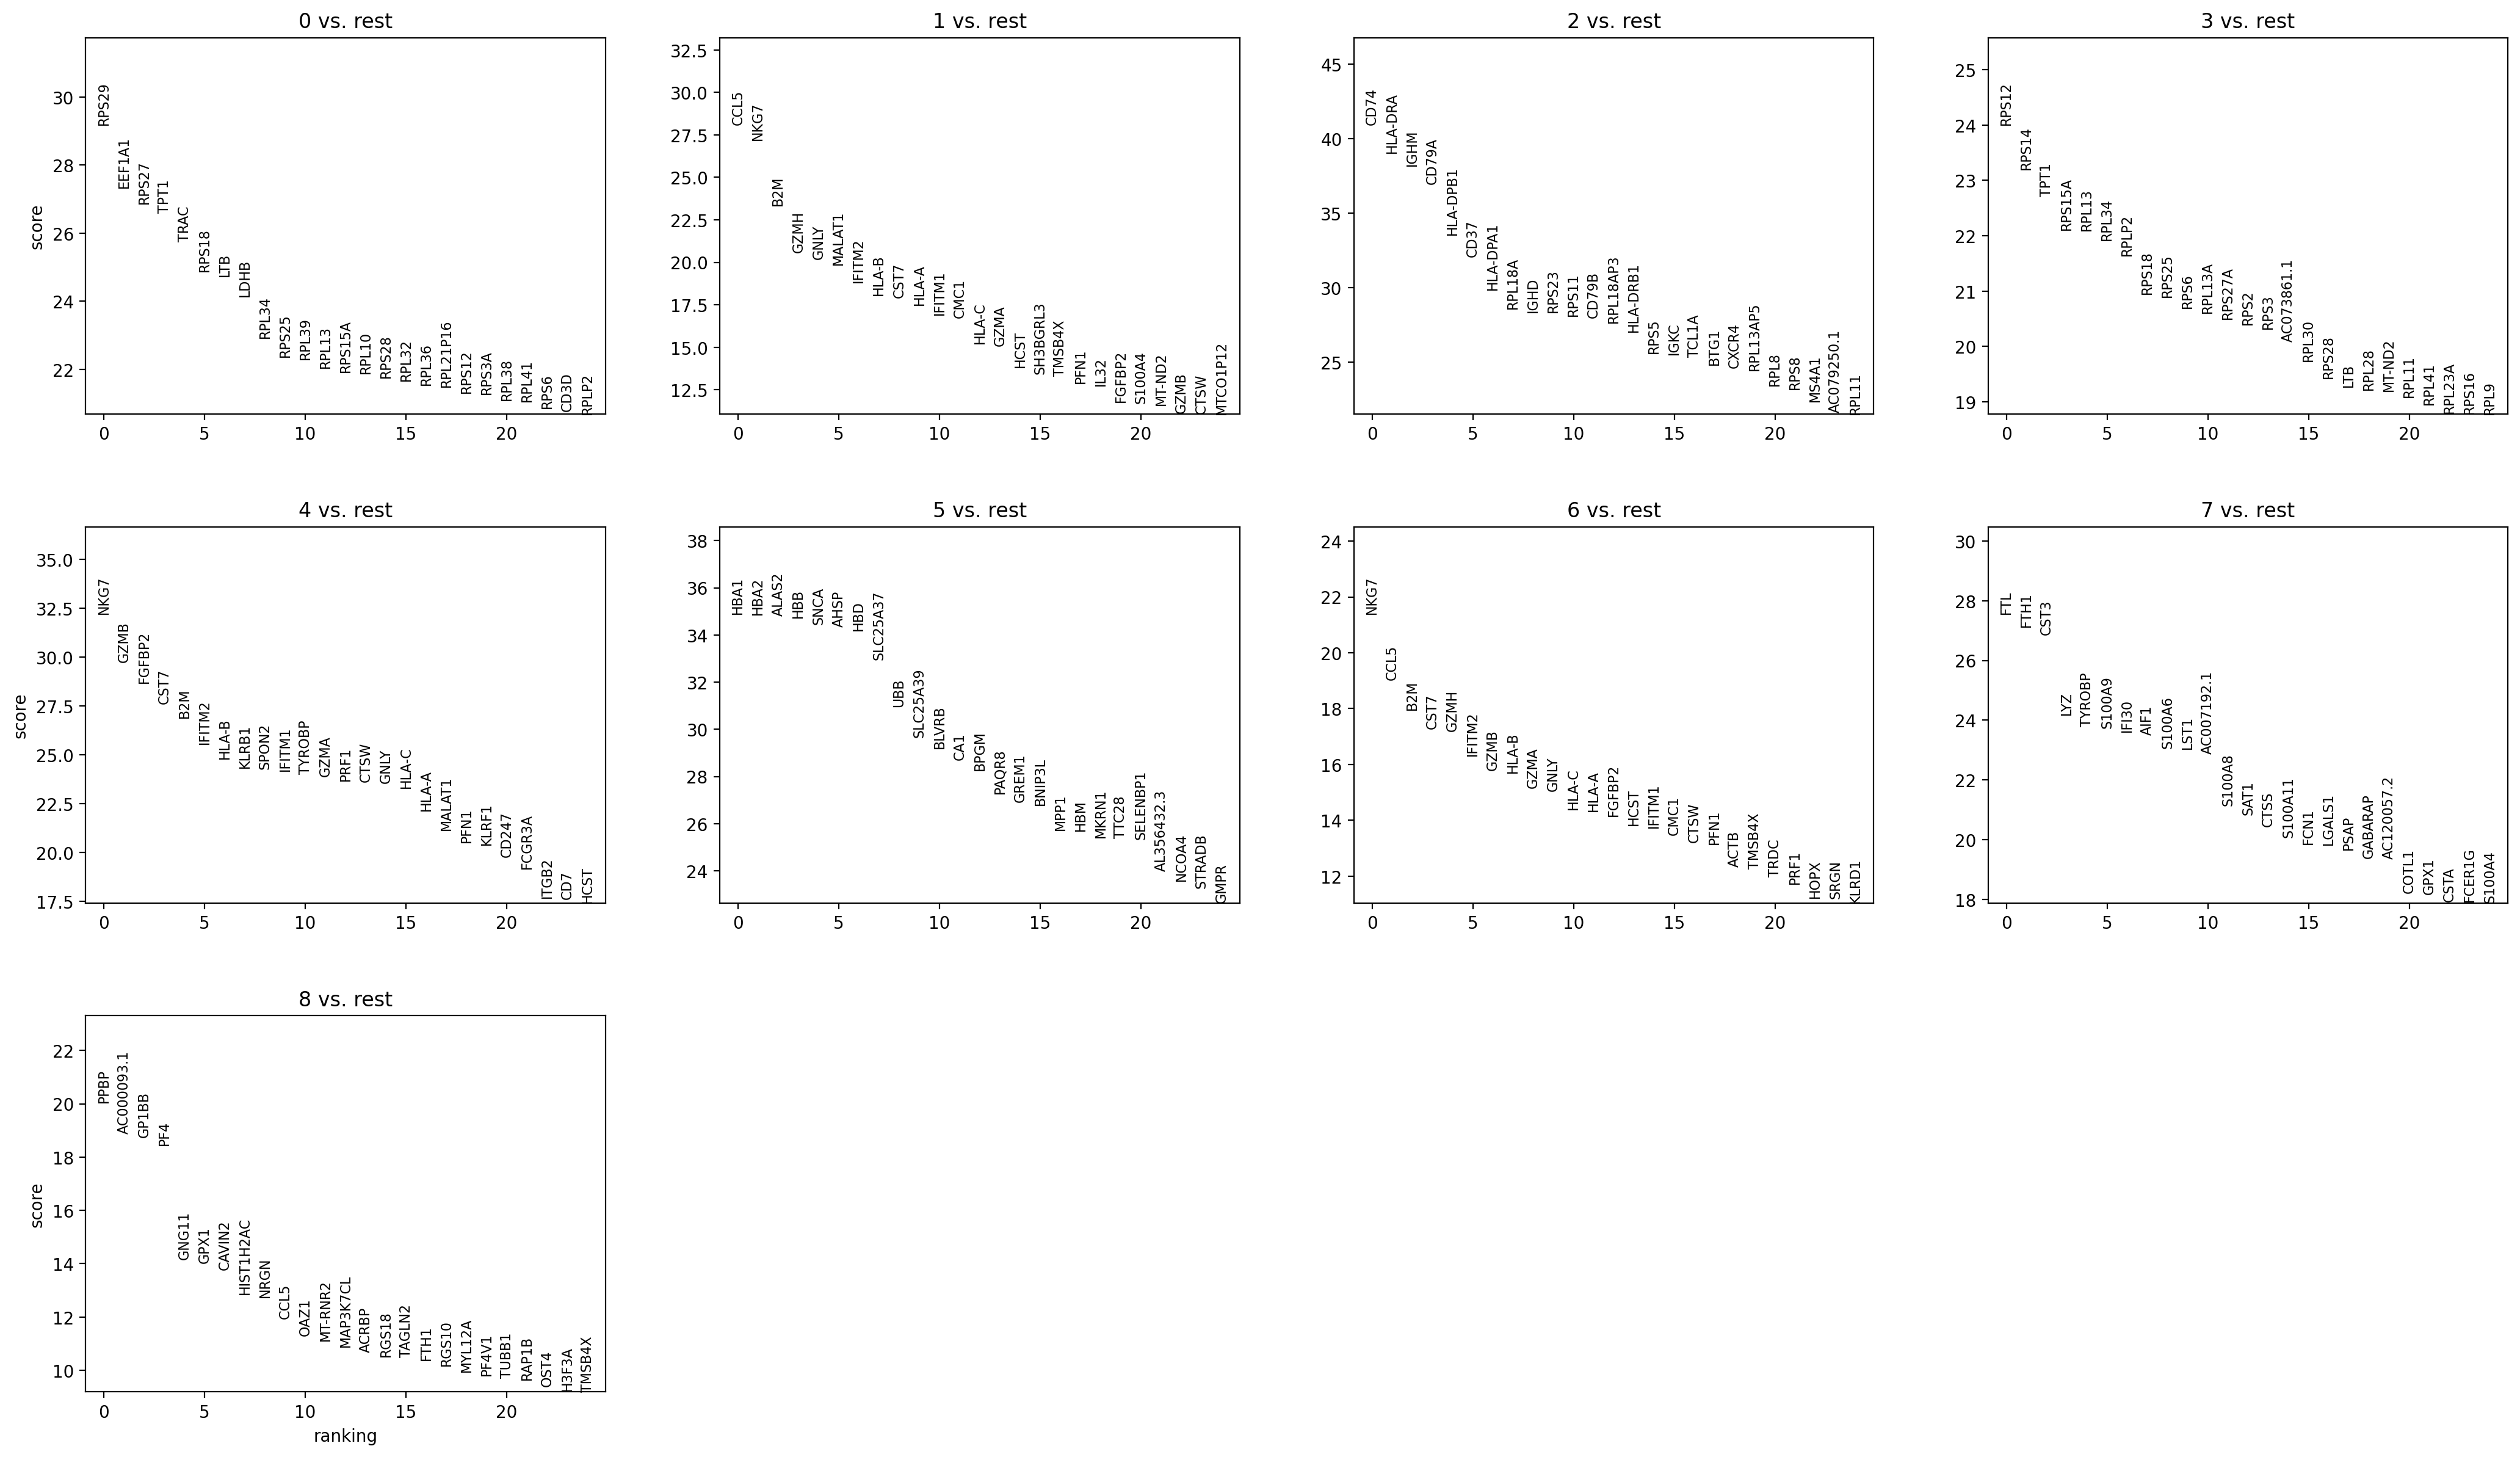

In [333]:
sc.tl.rank_genes_groups(adata_merged, 'louvain', method='wilcoxon', use_raw=True)
sc.pl.rank_genes_groups(adata_merged, n_genes=25, sharey=False)

### Show top 10 ranked genes per cluster

In [334]:
pd.DataFrame(adata_merged.uns['rank_genes_groups']['names']).head(10)

0       1         2       3       4         5       6       7  \
0   RPS29    CCL5      CD74   RPS12    NKG7      HBA1    NKG7     FTL   
1  EEF1A1    NKG7   HLA-DRA   RPS14    GZMB      HBA2    CCL5    FTH1   
2   RPS27     B2M      IGHM    TPT1  FGFBP2     ALAS2     B2M    CST3   
3    TPT1    GZMH     CD79A  RPS15A    CST7       HBB    CST7     LYZ   
4    TRAC    GNLY  HLA-DPB1   RPL13     B2M      SNCA    GZMH  TYROBP   
5   RPS18  MALAT1      CD37   RPL34  IFITM2      AHSP  IFITM2  S100A9   
6     LTB  IFITM2  HLA-DPA1   RPLP2   HLA-B       HBD    GZMB   IFI30   
7    LDHB   HLA-B    RPL18A   RPS18   KLRB1  SLC25A37   HLA-B    AIF1   
8   RPL34    CST7      IGHD   RPS25   SPON2       UBB    GZMA  S100A6   
9   RPS25   HLA-A     RPS23    RPS6  IFITM1  SLC25A39    GNLY    LST1   

            8  
0        PPBP  
1  AC000093.1  
2       GP1BB  
3         PF4  
4       GNG11  
5        GPX1  
6      CAVIN2  
7   HIST1H2AC  
8        NRGN  
9        CCL5

subset the marker genes map to keep the markers exist in top 10 ranked markers

In [357]:
top_ranked_genes = pd.DataFrame(adata_merged.uns['rank_genes_groups']['names']).head(10).values
exprd_marker_genes = dict()
for ct, markers in marker_genes.items():
    found = []
    for marker in markers:
        if marker in adata_merged.var.index:
            found.append(marker)
    if found:
        exprd_marker_genes[ct] = found

Here is the cell type map of top ranked marker genes

In [358]:
exprd_marker_genes

{'CD14+ Mono': ['FCN1', 'CD14'],
 'CD16+ Mono': ['TCF7L2', 'FCGR3A', 'LYN'],
 'ID2-hi myeloid prog': ['CD14',
  'ID2',
  'VCAN',
  'S100A9',
  'CLEC12A',
  'KLF4',
  'PLAUR'],
 'cDC1': ['CLEC9A', 'CADM1'],
 'cDC2': ['CST3', 'COTL1', 'LYZ', 'DMXL2', 'CLEC10A', 'FCER1A'],
 'Normoblast': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'],
 'Erythroblast': ['MKI67', 'HBA1', 'HBB'],
 'Proerythroblast': ['CDK6', 'SYNGR1', 'HBM', 'GYPA'],
 'NK': ['GNLY',
  'NKG7',
  'CD247',
  'GRIK4',
  'FCER1G',
  'TYROBP',
  'KLRG1',
  'FCGR3A'],
 'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1'],
 'Lymph prog': ['VPREB1',
  'MME',
  'EBF1',
  'SSBP2',
  'BACH2',
  'CD79B',
  'IGHM',
  'PAX5',
  'PRKCE',
  'DNTT',
  'IGLL1'],
 'Naive CD20+ B': ['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM'],
 'B1 B': ['MS4A1',
  'SSPN',
  'ITGB1',
  'EPHA4',
  'COL4A4',
  'PRDM1',
  'IRF4',
  'CD38',
  'XBP1',
  'PAX5',
  'BCL11A',
  'BLK',
  'IGHD',
  'IGHM',
  'ZNF215'],
 'Transitional B': ['MME', 'CD38', 'CD24', 'ACSM3', 'MSI2'],


### Visualizing 5 most differentially expressed gene in each cluster

#### Dotplot with filter

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


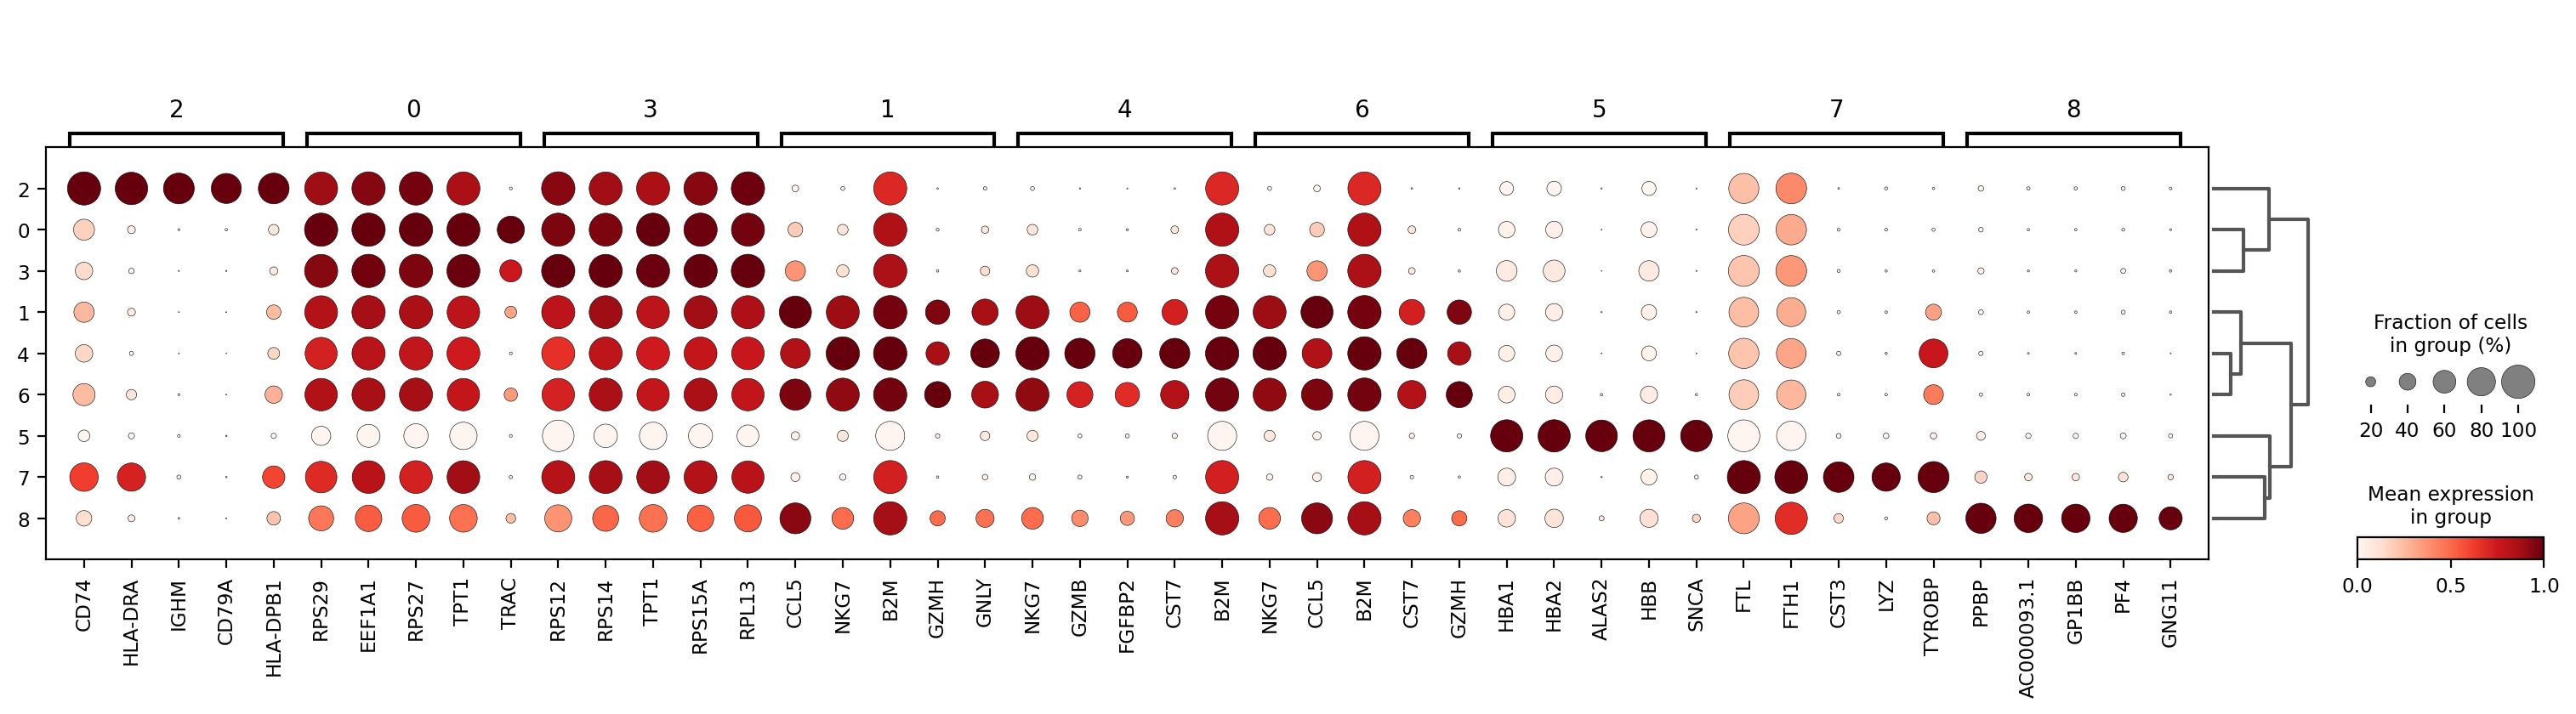

In [351]:
sc.pl.rank_genes_groups_dotplot(
    adata_merged, 
    groupby="louvain", 
    standard_scale="var", 
    n_genes=5,
    key='rank_genes_groups'
)

To better differentiate expressed marker genes, in-out groups fraction filter is applied

In [354]:
sc.tl.filter_rank_genes_groups(
    adata_merged,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
    key='rank_genes_groups',
    key_added='rank_genes_groups_filtered'
)

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


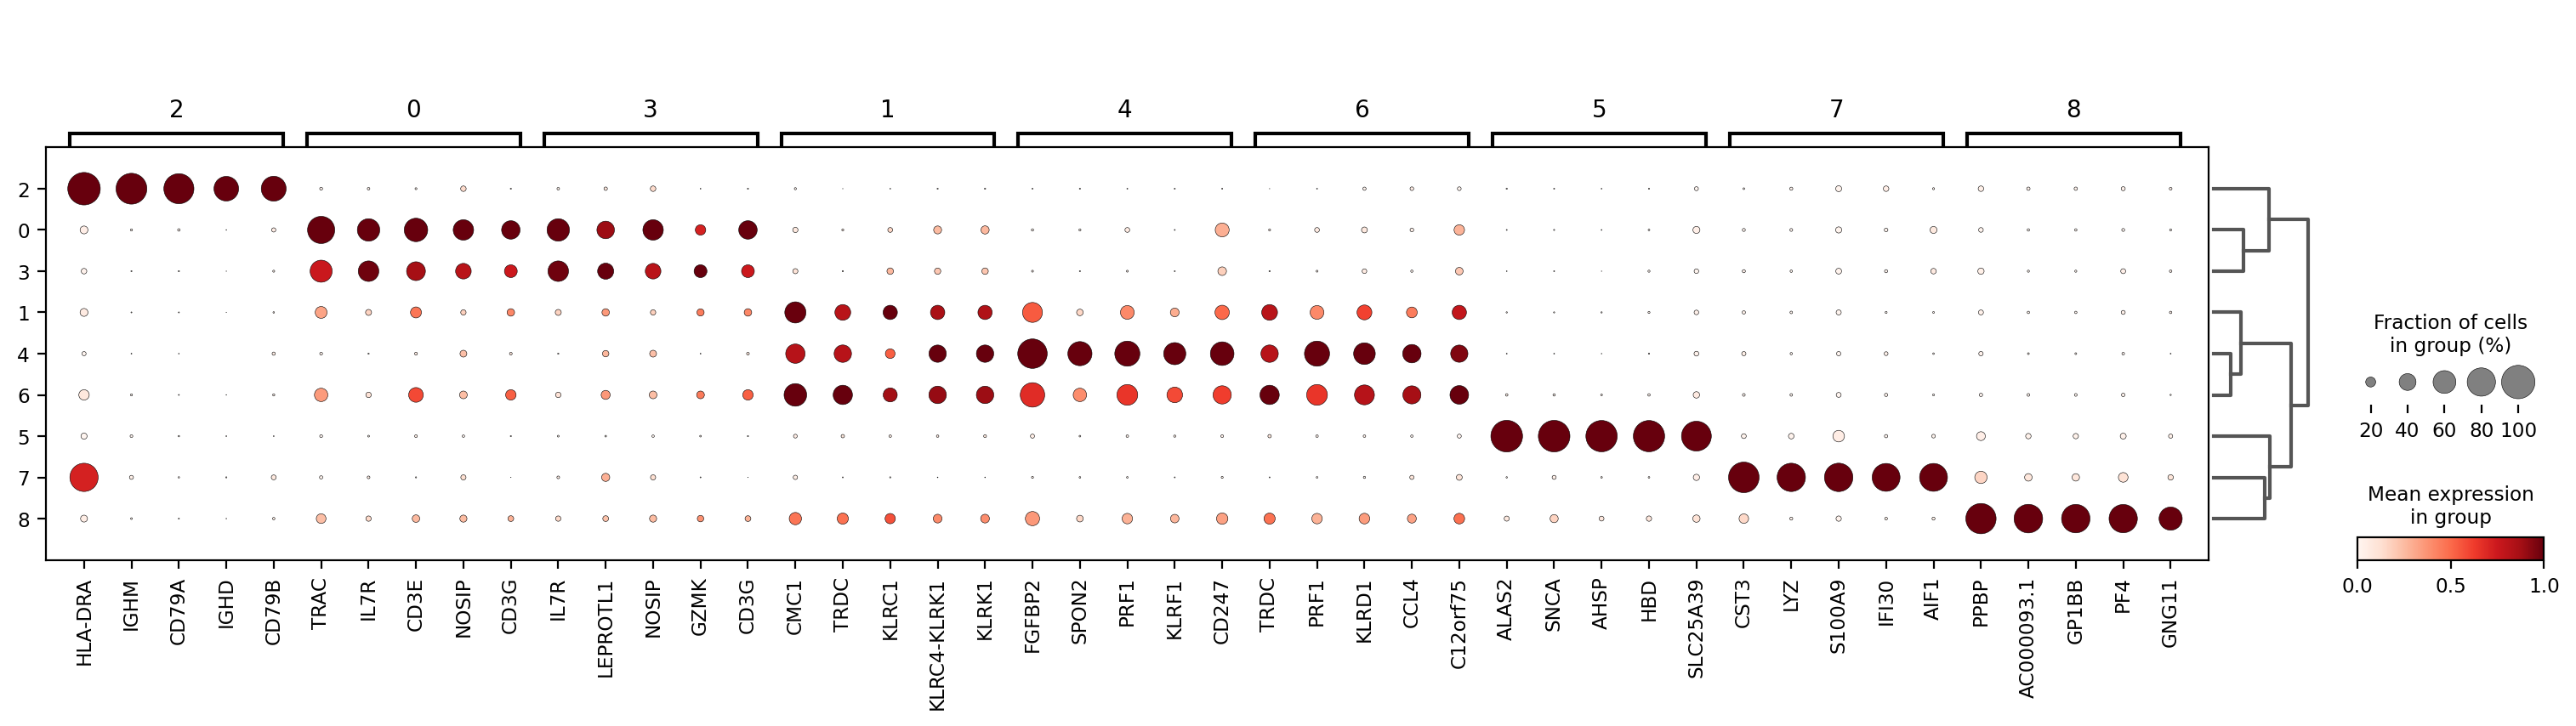

In [355]:
sc.pl.rank_genes_groups_dotplot(
    adata_merged, 
    groupby="louvain", 
    standard_scale="var", 
    n_genes=5,
    key='rank_genes_groups_filtered'
)

In [375]:
l_2 = ['HLA-DRA', 'IGHM', 'CD79A']
for ct, markers in exprd_marker_genes.items():
    for marker in l_2:
        if marker in markers:
            print(ct)

Lymph prog
Naive CD20+ B
B1 B


### Check each marker genes in t-sne plot

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


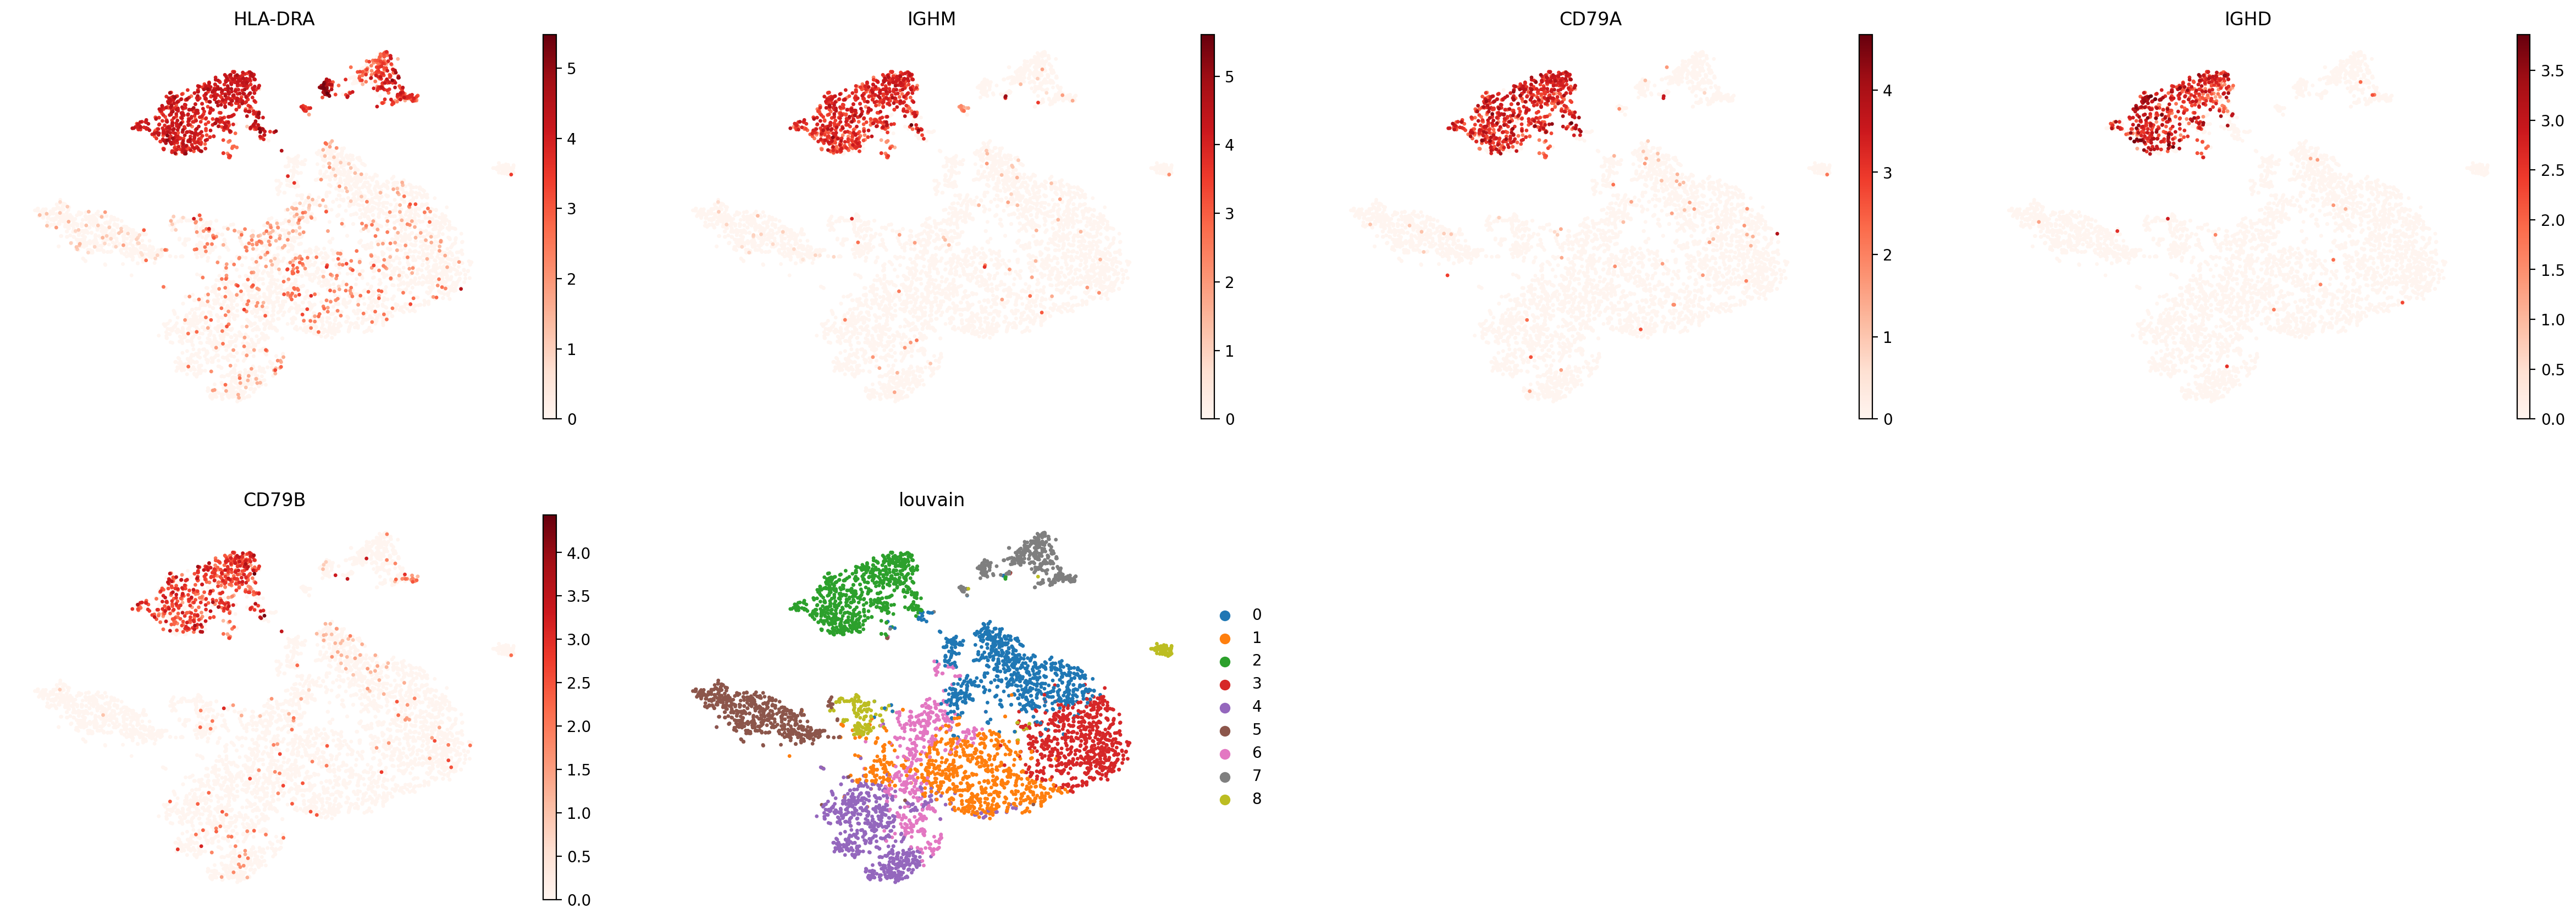

In [365]:
sc.pl.tsne(adata_merged,
          color=['HLA-DRA', 'IGHM', 'CD79A', 'IGHD', 'CD79B', 'louvain'],
          frameon=False,
          cmap='Reds')

## Expression of the top 10 marker genes in cells for each cluster

In [ ]:
sc.pl.rank_genes_groups_heatmap(adatas[0], n_genes=10, groupby='louvain', key='rank_genes_groups', show_gene_labels=True)

In [ ]:
for adata, sp in zip(adatas, samples):
    adata.raw.to_adata().write(f'/Users/liu.yak/Code/10x_sequence_analysis_pipeline/count_out_{sp}/counts_unfiltered/{sp}_mtx_only.h5ad')